#Top

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindsayalexandra14/ds_portfolio/blob/main/1_projects/machine_learning/NLP/restaurant_prediction_nlp/restaurant_prediction_nlp.ipynb)


In [ ]:
try:
    import gensim
except ImportError:
    !pip install gensim
    import gensim

📦 This notebook requires `gensim`.  
Run the install cell above first. If Colab asks you to restart the runtime, do that, then re-run the notebook from the top.


#Intro

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Restaurant%20Classification%20NLP.png)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Introduction.png)



*  Author: Lindsay McFarlane
*  Date: May 2025
*  Objective: Predict restaurant type from restaurant data using any type of NLP model
* Goal: Weighted F1 above ~75%, outperforming given baseline model
* Result: 82.9% weighted F1-Score (vs. 75% baseline), an improvement of ~10.5% + over baseline
* Data: 3rd party data (from UCSD NLP Class) on restaurant reviews & other restaurant features
* Models:

    1.   Avg. word embeddings of restaurant reviews (baseline)
    2.   Avg. Word Embeddings (review + features)
    3.   BERT Transformer (on reviews)
    4.   BERT Transformer on reviews + features
    5.   RoBERTA Transformer on reviews & features



<-Can also access Google Colab TOC in left toolbar (bullets icon)

>[Top](#scrollTo=GBFyDjOFwDPi)

>[Intro](#scrollTo=hjEpMGVfv8bY)

>>[Import Data](#scrollTo=Rhq9-i6WaWOO)

>>[View Data](#scrollTo=yOWoCaNkYtS-)

>[Data Preparation](#scrollTo=cK4PnORqYp5Y)

>[Initial Dimension Reduction](#scrollTo=WAD9194iRmst)

>[EDA](#scrollTo=K6D3CQoVZGPb)

>[Dimension Reduction](#scrollTo=sNI3285xZLw3)

>[Average Embedding Models](#scrollTo=h99-Cxve7Bv3)

>>[Data Pre-Processing](#scrollTo=BQrAAU1a1J3b)

>>[Model 1](#scrollTo=ir7d2aDE6Nk0)

>>[Model 2](#scrollTo=sfRa7_EW6Bw6)

>[BERT Transformer Models](#scrollTo=dmyCqwti0l9y)

>>[Model 3](#scrollTo=LRmbbe9-NRXH)

>>[Model 4](#scrollTo=JL5WNzgt2sP8)

>[RoBERTa Transformer Model](#scrollTo=_VUOlEPd0uiM)

>>[Model 5](#scrollTo=qy-UWADF18FP)

>[Model Comparison](#scrollTo=NSljNK9KRc7i)



![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/tl;dr.png)

This project predicts restaurant type from restaurant reviews OR restaurant reviews + other restaurant features using the following models. This was the final performance:

 ![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/1_projects/machine_learning/NLP/restaurant_prediction_nlp/final_accuracy_report.png)

![Alt Text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/1_projects/machine_learning/NLP/restaurant_prediction_nlp/final_classification_report.png)

##Import Data

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Import%20Data.png)

In [ ]:
!wget "https://raw.githubusercontent.com/lindsayalexandra14/ds_portfolio/refs/heads/main/1_projects/machine_learning/NLP/restaurant_prediction_nlp/train.csv"
!wget "https://raw.githubusercontent.com/lindsayalexandra14/ds_portfolio/refs/heads/main/1_projects/machine_learning/NLP/restaurant_prediction_nlp/test.csv"


In [ ]:
import pandas as pd
import numpy as np

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

##View Data

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/View%20Data.png)

View shape of data:

*   13k rows and 62 features for training data
*   10k rows and 61 features for test data (same features but does not have 'label' > one fewer feature)



In [ ]:
print(df_train.shape)
print(df_test.shape)

(13144, 62)
(10000, 61)


*Note: The given "test set" is unlabeled so won't be used here and was only used for Kaggle scoring in the platform*

View names of all features/columns:

In [ ]:
print(df_train. columns)

Index(['id', 'attributes.HappyHour', 'attributes.Ambience', 'hours.Tuesday',
       'postal_code', 'attributes.AgesAllowed', 'attributes.GoodForDancing',
       'attributes.OutdoorSeating', 'hours.Saturday', 'attributes.Corkage',
       'longitude', 'name', 'attributes.BusinessAcceptsCreditCards',
       'attributes.RestaurantsTableService',
       'attributes.RestaurantsReservations', 'hours.Friday',
       'attributes.RestaurantsPriceRange2', 'attributes.WiFi',
       'attributes.ByAppointmentOnly', 'attributes.Music',
       'attributes.NoiseLevel', 'attributes.BYOB', 'state',
       'attributes.Alcohol', 'attributes.HasTV', 'attributes',
       'attributes.BYOBCorkage', 'hours.Wednesday', 'hours.Sunday',
       'attributes.RestaurantsGoodForGroups', 'attributes.Open24Hours',
       'attributes.BusinessParking', 'attributes.DogsAllowed',
       'attributes.HairSpecializesIn', 'review_count', 'is_open',
       'attributes.Caters', 'attributes.CoatCheck', 'attributes.BikeParking',
   

#Data Preparation

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Data%20Preparation.png)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Missing%20Values.png)

Create dataframe of features with their count and % of missing values (if above 0 -> they had missing values):

In [ ]:
missing_df = pd.DataFrame({
    'Missing Count': df_train.isnull().sum(),
    'Missing %': (df_train.isnull().sum() / len(df_train)) * 100
})
missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

,Missing Count,Missing %
attributes.HairSpecializesIn,13144,100.000000
attributes.Open24Hours,13143,99.992392
attributes.DietaryRestrictions,13143,99.992392
attributes.AcceptsInsurance,13142,99.984784
attributes.RestaurantsCounterService,13141,99.977176
attributes.BYOB,13139,99.961960
attributes.AgesAllowed,13132,99.908704
attributes.ByAppointmentOnly,13031,99.140292
attributes.Corkage,12962,98.615338
attributes.BYOBCorkage,12701,96.629641


 Drop columns with more than 70% missing:

In [ ]:
# Threshold to keep columns with at least 30% non-null values
threshold = 0.30

original_cols = df_train.columns

valid_cols = df_train.columns[df_train.isnull().mean() < (1 - threshold)]

# Except keep the bitcoin feature despite its missingness %
# I thought this might have unique compelling meaning in word embeddings but it didn't
if "attributes.BusinessAcceptsBitcoin" in df_train.columns and \
   "attributes.BusinessAcceptsBitcoin" not in valid_cols:
    valid_cols = valid_cols.append(pd.Index(["attributes.BusinessAcceptsBitcoin"]))

# Drop columns in original_cols but NOT in valid_cols
dropped_cols = original_cols.difference(valid_cols)

print(f"Columns dropped ({len(dropped_cols)}):")
print(dropped_cols.tolist())

# Set dataframes to only include valid columns for training and test
df_train = df_train[valid_cols]
df_test = df_test[valid_cols.intersection(df_test.columns)]


Columns dropped (19):
['attributes.AcceptsInsurance', 'attributes.AgesAllowed', 'attributes.BYOB', 'attributes.BYOBCorkage', 'attributes.BestNights', 'attributes.ByAppointmentOnly', 'attributes.CoatCheck', 'attributes.Corkage', 'attributes.DietaryRestrictions', 'attributes.DogsAllowed', 'attributes.DriveThru', 'attributes.GoodForDancing', 'attributes.HairSpecializesIn', 'attributes.HappyHour', 'attributes.Music', 'attributes.Open24Hours', 'attributes.RestaurantsCounterService', 'attributes.Smoking', 'attributes.WheelchairAccessible']


View updated data shape and features:

In [ ]:
print(df_train.shape)
print(df_test.shape)
print(df_train.columns)
print(df_test.columns)

(13144, 43)
(10000, 42)
Index(['id', 'attributes.Ambience', 'hours.Tuesday', 'postal_code',
       'attributes.OutdoorSeating', 'hours.Saturday', 'longitude', 'name',
       'attributes.BusinessAcceptsCreditCards',
       'attributes.RestaurantsTableService',
       'attributes.RestaurantsReservations', 'hours.Friday',
       'attributes.RestaurantsPriceRange2', 'attributes.WiFi',
       'attributes.NoiseLevel', 'state', 'attributes.Alcohol',
       'attributes.HasTV', 'attributes', 'hours.Wednesday', 'hours.Sunday',
       'attributes.RestaurantsGoodForGroups', 'attributes.BusinessParking',
       'review_count', 'is_open', 'attributes.Caters',
       'attributes.BikeParking', 'hours.Monday', 'city', 'stars',
       'attributes.RestaurantsTakeOut', 'latitude', 'business_id',
       'hours.Thursday', 'attributes.RestaurantsAttire',
       'attributes.RestaurantsDelivery', 'address', 'attributes.GoodForKids',
       'attributes.GoodForMeal', 'hours', 'label', 'review',
       'attribute

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Removing%20Characters.png)

View state of formatting:

In [ ]:
print(df_train.head())

   id                                attributes.Ambience hours.Tuesday  \
0   0  b"{'romantic': False, 'intimate': False, 'clas...   b'15:0-2:0'   
1   1  b"{'romantic': False, 'intimate': False, 'tour...  b'11:0-21:0'   
2   2                                                NaN  b'11:0-21:0'   
3   3  b"{'romantic': False, 'intimate': False, 'clas...           NaN   
4   4  b"{'romantic': False, 'intimate': False, 'tour...           NaN   

  postal_code attributes.OutdoorSeating hours.Saturday   longitude  \
0    b'44107'                  b'False'   b'11:30-2:0'  -81.820568   
1    b'85042'                   b'True'  b'11:0-20:30' -112.032893   
2  b'M4M 3G6'                       NaN   b'11:0-21:0'  -79.339163   
3    b'89146'                  b'False'            NaN -115.242714   
4    b'44133'                  b'False'            NaN  -81.726357   

                      name attributes.BusinessAcceptsCreditCards  \
0              b'Rush Inn'                               b'True'  

Fix string formatting, first combining the training and test to apply formatting to both datasets at once. Then remove byte-string (b'), unicode-string (u'), and quote characters from the data:

In [ ]:
df_train["source"] = "train"
df_test["source"] = "test"
combined = pd.concat([df_train, df_test], axis=0)

combined = combined.apply(lambda col: col.astype(str).str.replace(r"^b'|^b\"|\"|'|u'", '', regex=True))

Split data back into training and test sets:

In [ ]:
df_train = combined[combined["source"] == "train"].drop("source", axis=1)
df_test = combined[combined["source"] == "test"].drop("source", axis=1)

View data to check that characters were removed and formatting looks usable:

In [ ]:
print(df_train.head())

  id                                attributes.Ambience hours.Tuesday  \
0  0  {romantic: False, intimate: False, classy: Fal...      15:0-2:0   
1  1  {romantic: False, intimate: False, touristy: F...     11:0-21:0   
2  2                                                nan     11:0-21:0   
3  3  {romantic: False, intimate: False, classy: Fal...           nan   
4  4  {romantic: False, intimate: False, touristy: F...           nan   

  postal_code attributes.OutdoorSeating hours.Saturday     longitude  \
0       44107                     False      11:30-2:0  -81.82056826   
1       85042                      True     11:0-20:30  -112.0328928   
2     M4M 3G6                       nan      11:0-21:0   -79.3391627   
3       89146                     False            nan   -115.242714   
4       44133                     False            nan   -81.7263567   

                   name attributes.BusinessAcceptsCreditCards  \
0              Rush Inn                                  True  

Note, the combining and separating the train and test sets above gave a 'label' column to the test set, just with na's. Won't be pulled in later, but good to know:

In [ ]:
print(df_test['label'])

0       nan
1       nan
2       nan
3       nan
4       nan
       ... 
9995    nan
9996    nan
9997    nan
9998    nan
9999    nan
Name: label, Length: 10000, dtype: object


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Handle%20Null%20Values.png)

Make 'None's in a consistent format:
Replace actual NaNs with the string 'None'.
Normalize anything that *means* 'None' (case-insensitive):

In [ ]:
df_train = df_train.fillna('None')
df_train = df_train.applymap(lambda x: 'None' if str(x).strip().lower() in ['none', 'nan', 'b\'none\'', 'b"none"'] else x)


Apply same formatting to the test data:

In [ ]:
df_test = df_test.fillna('None')

df_test = df_test.applymap(lambda x: 'None' if str(x).strip().lower() in ['none', 'nan', 'b\'none\'', 'b"none"'] else x)

#Initial Dimension Reduction

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Initial%20Dimension%20Reduction.png)

Drop features:

*   id, business_id - not informative
*   latitude, longitude, address, postal code, city, hours - too granular
*   is_open, review count - not indicative of type
*  parking (bike, business) - not indicative of type, one field is too complex for low value, mostly dependent on the city/location
*   attributes is a field of all the attributes combined - don't want all
*   stars is numeric, we want text data for NLP


Drop columns that will definitely not be used:

In [ ]:
columns_to_drop = ['id','business_id','latitude','longitude','hours','address', 'postal_code','city',
                   'hours.Monday','hours.Tuesday','hours.Wednesday','hours.Thursday',
                   'hours.Friday','hours.Saturday', 'hours.Sunday',
                   'attributes.BusinessParking','attributes.BikeParking',
                   'is_open','review_count','attributes', 'stars']
df_train = df_train.drop(columns_to_drop, axis=1)
df_test= df_test.drop(columns_to_drop, axis=1)

In [ ]:
print(df_train.columns)

Index(['attributes.Ambience', 'attributes.OutdoorSeating', 'name',
       'attributes.BusinessAcceptsCreditCards',
       'attributes.RestaurantsTableService',
       'attributes.RestaurantsReservations',
       'attributes.RestaurantsPriceRange2', 'attributes.WiFi',
       'attributes.NoiseLevel', 'state', 'attributes.Alcohol',
       'attributes.HasTV', 'attributes.RestaurantsGoodForGroups',
       'attributes.Caters', 'attributes.RestaurantsTakeOut',
       'attributes.RestaurantsAttire', 'attributes.RestaurantsDelivery',
       'attributes.GoodForKids', 'attributes.GoodForMeal', 'label', 'review',
       'attributes.BusinessAcceptsBitcoin'],
      dtype='object')


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Feature%20Engineering.png)

The feature engineering that I performed is largely to provide as much concise, text-rich info as possible phrased in a Natural Language way that BERT would interpret better. For example: "Arizona" instead of "AZ" (for a state) or "Moderate Price" instead of "PriceRange: 2."

Note, first relabeling the review field to "text" as it's more intuitive and standard as an input feature name for the NLP tokenizing functions. Then the "review" field is included as a field to drop:

In [ ]:
df_train["text"] = df_train["review"]
df_test["text"] = df_test["review"]

I viewed the unique states in the 'state' column in order to build a state map to assign their exact state names to the values so that it has more specific/useful text information to feed the natural language processing model.

This is important, for example, to identify the Candadian states (e.g., for 'Quebec Canada' the word 'Canada' can be picked up in the model and help predict the 'Canadian restaurant' type).

There are other ways to group the data and assign regions to it but there were not that many states so I did not group them. Adding the full state names in the model though should provide clearer info for the word embeddings, in addition to adding the Canadian tag:

In [ ]:
print(df_train["state"].unique())

['OH' 'AZ' 'ON' 'NV' 'SC' 'WI' 'QC' 'PA' 'NC' 'AB' 'IL' 'VA']


In [ ]:
state_map = {
    "QC": "Quebec Canada",
    "ON": "Ontario Canada",
    "BC": "British Columbia Canada",
    "AZ": "Arizona",
    "OH": "Ohio",
    "NV": "Nevada",
    "SC": "South Carolina",
    "WI": "Wisconsin",
    "PA": "Philadelphia",
    "NC": "North Carolina",
    "IL": "Illinois",
    "VA": "Virginia",
    "AB": "Alberta Canada"
}

df_train["state"] = df_train["state"].map(state_map).fillna(df_train["state"])
df_test["state"] = df_test["state"].map(state_map).fillna(df_test["state"])


Add "located in" to state to make it more of a natural language phrase (will do later for "name" -> Restaurant's name: ___" later as well):

In [ ]:
df_train["state"] = df_train["state"].apply(lambda x: f"Located in {x}")
df_test["state"]=df_test["state"].apply(lambda x: f"Located in {x}")

Confirm mapping and show new 'state' values:

In [ ]:
print(df_train["state"].unique())

['Located in Ohio' 'Located in Arizona' 'Located in Ontario Canada'
 'Located in Nevada' 'Located in South Carolina' 'Located in Wisconsin'
 'Located in Quebec Canada' 'Located in Philadelphia'
 'Located in North Carolina' 'Located in Alberta Canada'
 'Located in Illinois' 'Located in Virginia']


Inspect 'attribute' columns and their unique values because they have the same complex structure. Some were True/False/None but some were dictionaries. They will need to be reformatted:

In [ ]:
for col in df_train.columns:
    if col.startswith("attributes."):
        print(f"\nColumn: {col}")
        print(df_train[col].dropna().astype(str).unique().tolist())

I viewed the 'Attire' values and wanted to maintain the word "attire" for the model to read and only keep the values that have valuable text info so I reformatted and removed the 'None' values:

In [ ]:
print(df_train["attributes.RestaurantsAttire"].unique())

['casual' 'None' 'dressy' 'formal']


In [ ]:
def map_attire(value):
    if value == "casual":
        return "Casual attire"
    elif value == "dressy":
        return "Dressy attire"
    elif value == "formal":
        return "Formal attire"
    else:
        return ""  # For None or anything else

df_train["attributes.RestaurantsAttire"] = df_train["attributes.RestaurantsAttire"].apply(map_attire)
df_test["attributes.RestaurantsAttire"] = df_test["attributes.RestaurantsAttire"].apply(map_attire)


In [ ]:
def map_wifi(value):
    if value == "free":
        return "Free WiFi"
        #['no', 'None', 'free', 'paid']
    elif value == "paid":
        return "Paid WiFi"
    else:
        return ""  # For None or anything else

df_train["attributes.WiFi"] = df_train["attributes.WiFi"].apply(map_wifi)
df_test["attributes.WiFi"] = df_test["attributes.WiFi"].apply(map_wifi)


In [ ]:
def map_noise(value):
    if value == "loud":
        return "Noisy"
    elif value == "quiet":
        return "Quiet"
    elif value == "average":
        return "Average noise"
    elif value == "very_loud":
        return "Very noisy"
    else:
        return ""  # For None or anything else
        #['loud', 'quiet', 'None', 'average', 'very_loud']

df_train["attributes.NoiseLevel"] = df_train["attributes.NoiseLevel"].apply(map_noise)
df_test["attributes.NoiseLevel"] = df_test["attributes.NoiseLevel"].apply(map_noise)


I adjusted the "Good for Kids" field to "Kid-friendly so that the text information is again in the values instead of just saying True False and also so it is concise enough to be well-interpreted by the word embeddings in the model:

The falses are kept in for the EDA but are later removed. This "no false" version (meaning I didn't also add "Not Kid-Friendly" for the Good for Kids field when adding "Kid-friendly") performed better for these types of features where there was a True False, implying the negative versions are likely adding noise so my strategy was to only keep the positive values and make them as concise and word embedding friendly as possible. This way it was more likely to produce a cleaner signal for the words.

In [ ]:
def map_good_for_kids(value):
    if value is True or value == "True":
        return "Kid-friendly"
    elif value is False or value == "False":
        return "False"
    else:
        return ""  # For None or anything else

df_train["attributes.GoodForKids"] = df_train["attributes.GoodForKids"].apply(map_good_for_kids)
df_test["attributes.GoodForKids"] = df_test["attributes.GoodForKids"].apply(map_good_for_kids)


In [ ]:
print(df_train["attributes.GoodForKids"].head())

0           False
1    Kid-friendly
2                
3    Kid-friendly
4    Kid-friendly
Name: attributes.GoodForKids, dtype: object


I performed the same formatting adjustment on the fields below so that they also include as much text information as possible to feed the natural language model.

In [ ]:
def map_delivery(value):
    if value is True or value == "True":
        return "Delivery"
    elif value is False or value == "False":
        return "False"
    else:
        return ""  # For None or anything else

df_train["attributes.RestaurantsDelivery"] = df_train["attributes.RestaurantsDelivery"].apply(map_delivery)
df_test["attributes.RestaurantsDelivery"] = df_test["attributes.RestaurantsDelivery"].apply(map_delivery)


 For 'Price' I gave them low, moderate, high, very high price for the same reason:

In [ ]:
print(df_train["attributes.RestaurantsPriceRange2"].unique())

['2' 'None' '1' '3' '4']


In [ ]:
def map_pricerange(value):
    if value =='1':
        return "Low Price"
    elif value =='2':
        return "Moderate Price"
    elif value =='3':
        return "High Price"
    elif value =='4':
        return "Very High Price"
    else:
        return ""  # For None or anything else

df_train["attributes.RestaurantsPriceRange2"] = df_train["attributes.RestaurantsPriceRange2"].apply(map_pricerange)
df_test["attributes.RestaurantsPriceRange2"] = df_test["attributes.RestaurantsPriceRange2"].apply(map_pricerange)


In [ ]:
print(df_train['attributes.RestaurantsPriceRange2'].head())

0    Moderate Price
1    Moderate Price
2                  
3         Low Price
4         Low Price
Name: attributes.RestaurantsPriceRange2, dtype: object


In [ ]:
def map_cc(value):
    if value is True or value == "True":
        return "Accepts Credit Cards"
    elif value is False or value == "False":
        return "False"
    else:
        return ""  # For None or anything else

df_train["attributes.BusinessAcceptsCreditCards"] = df_train["attributes.BusinessAcceptsCreditCards"].apply(map_cc)
df_test["attributes.BusinessAcceptsCreditCards"] = df_test["attributes.BusinessAcceptsCreditCards"].apply(map_cc)


In [ ]:
def map_bitcoin(value):
    if value is True or value == "True":
        return "Accepts Bitcoin"
    elif value is False or value == "False":
        return "False"
    else:
        return ""  # For None or anything else

df_train["attributes.BusinessAcceptsBitcoin"] = df_train["attributes.BusinessAcceptsBitcoin"].apply(map_bitcoin)
df_test["attributes.BusinessAcceptsBitcoin"] = df_test["attributes.BusinessAcceptsBitcoin"].apply(map_bitcoin)


In [ ]:
def map_outdoor_seating(value):
    if value is True or value == "True":
        return "Outdoor Seating"
    elif value is False or value == "False":
        return "False"
    else:
        return ""  # For None or anything else

df_train["attributes.OutdoorSeating"] = df_train["attributes.OutdoorSeating"].apply(map_outdoor_seating)
df_test["attributes.OutdoorSeating"] = df_test["attributes.OutdoorSeating"].apply(map_outdoor_seating)


In [ ]:
def map_tv(value):
    if value is True or value == "True":
        return "Has TV"
    elif value is False or value == "False":
        return "False"
    else:
        return ""  # For None or anything else

df_train["attributes.HasTV"] = df_train["attributes.HasTV"].apply(map_tv)
df_test["attributes.HasTV"] = df_test["attributes.HasTV"].apply(map_tv)


In [ ]:
def map_groups(value):
    if value is True or value == "True":
        return "Good for Groups"
    elif value is False or value == "False":
        return "False"
    else:
        return ""  # For None or anything else

df_train["attributes.RestaurantsGoodForGroups"] = df_train["attributes.RestaurantsGoodForGroups"].apply(map_groups)
df_test["attributes.RestaurantsGoodForGroups"] = df_test["attributes.RestaurantsGoodForGroups"].apply(map_groups)


In [ ]:
def map_tableservice(value):
    if value is True or value == "True":
        return "Table Service"
    elif value is False or value == "False":
        return "False"
    else:
        return ""  # For None or anything else

df_train["attributes.RestaurantsTableService"] = df_train["attributes.RestaurantsTableService"].apply(map_tableservice)
df_test["attributes.RestaurantsTableService"] = df_test["attributes.RestaurantsTableService"].apply(map_tableservice)


In [ ]:
def map_reservations(value):
    if value is True or value == "True":
        return "Takes reservations"
    elif value is False or value == "False":
        return "False"
    else:
        return ""  # For None or anything else

df_train["attributes.RestaurantsReservations"] = df_train["attributes.RestaurantsReservations"].apply(map_reservations)
df_test["attributes.RestaurantsReservations"] = df_test["attributes.RestaurantsReservations"].apply(map_reservations)


In [ ]:
def map_takeout(value):
    if value is True or value == "True":
        return "Takeout"
    elif value is False or value == "False":
        return "False"
    else:
        return ""  # For None or anything else

df_train["attributes.RestaurantsTakeOut"] = df_train["attributes.RestaurantsTakeOut"].apply(map_takeout)
df_test["attributes.RestaurantsTakeOut"] = df_test["attributes.RestaurantsTakeOut"].apply(map_takeout)


In [ ]:
def map_caters(value):
    if value is True or value == "True":
        return "Caters"
    elif value is False or value == "False":
        return "False"
    else:
        return ""  # For None or anything else

df_train["attributes.Caters"] = df_train["attributes.Caters"].apply(map_caters)
df_test["attributes.Caters"] = df_test["attributes.Caters"].apply(map_caters)


In [ ]:
def map_alcohol(value):
    if value == "beer_and_wine":
        return "Beer and Wine"
    elif value == "full_bar":
        return "Full bar"
    else:
        return ""  # For None or anything else

df_train["attributes.Alcohol"] = df_train["attributes.Alcohol"].apply(map_alcohol)
df_test["attributes.Alcohol"] = df_test["attributes.Alcohol"].apply(map_alcohol)


In [ ]:
type(df_train["attributes.GoodForMeal"].iloc[0])


str

'Good for Meal' and 'Ambience' had the string dictionary-type structure that needed major reformatting to parse out Ambience: casual: True, romantic: False for example to just 'casual'. Or 'Good for Dinner vs. 'Breakfast: False, Dinner: True, etc. This removes unnecessary words where things are False since the model can only take in so many words. This was an exception to keeping in the falses on the other features at this point to simplify this feature for the EDA.


In [ ]:
import re
import json

# Step 1: Convert the string into a usable dictionary
def parse_good_for_meal(row):
    if not isinstance(row, str) or row.strip() == "":
        return {}
    try:
        # Add quotes around keys and convert True/False to JSON compatible format
        fixed = re.sub(r'(\w+):', r'"\1":', row)  # keys
        fixed = fixed.replace("True", "true").replace("False", "false")  # booleans
        return json.loads(fixed)
    except Exception as e:
        # print(f"Failed to parse: {row}")
        return {}

# Step 2: Create readable label from True values
def label_good_meals(meal_dict):
    return ', '.join([f"Good for {k}" for k, v in meal_dict.items() if v is True])

# Step 3: Apply both steps
df_train["GoodForMeal_dict"] = df_train["attributes.GoodForMeal"].apply(parse_good_for_meal)
df_train["attributes.GoodForMeal"] = df_train["GoodForMeal_dict"].apply(label_good_meals)

df_test["GoodForMeal_dict"] = df_test["attributes.GoodForMeal"].apply(parse_good_for_meal)
df_test["attributes.GoodForMeal"] = df_test["GoodForMeal_dict"].apply(label_good_meals)



In [ ]:
import re
import json

# Step 1: Convert the string into a usable dictionary
def parse_ambience(row):
    if not isinstance(row, str) or row.strip() == "":
        return {}
    try:
        # Add quotes around keys and convert True/False to JSON compatible format
        fixed = re.sub(r'(\w+):', r'"\1":', row)  # keys
        fixed = fixed.replace("True", "true").replace("False", "false")  # booleans
        return json.loads(fixed)
    except Exception as e:
        # print(f"Failed to parse: {row}")
        return {}

# Step 2: Create readable label from True values
def label_ambience(ambience_dict):
    return ', '.join([f"{k}" for k, v in ambience_dict.items() if v is True])

# Step 3: Apply both steps
df_train["Ambience_dict"] = df_train["attributes.Ambience"].apply(parse_ambience)
df_train["attributes.Ambience"] = df_train["Ambience_dict"].apply(label_ambience)

df_test["Ambience_dict"] = df_test["attributes.Ambience"].apply(parse_ambience)
df_test["attributes.Ambience"] = df_test["Ambience_dict"].apply(label_ambience)


In [ ]:
df_train.drop(["GoodForMeal_dict", "Ambience_dict"], axis=1, inplace=True)
df_test.drop(["GoodForMeal_dict", "Ambience_dict"], axis=1, inplace=True)

Check examples for Good For Meal and Ambience. They have many unique values, so checking them this way vs. the ones with few unique values below it:

In [ ]:
print(df_train["attributes.GoodForMeal"].head(1))

0    Good for lunch, Good for dinner
Name: attributes.GoodForMeal, dtype: object


In [ ]:
print(df_train["attributes.Ambience"].head(1))

0    casual
Name: attributes.Ambience, dtype: object


Check new unique values for attribute features:

In [ ]:
for col in df_train.columns:
    if col.startswith("attributes.") and col not in ["attributes.GoodForMeal", "attributes.Ambience"]:
        print(f"\nColumn: {col}")
        print(df_train[col].dropna().astype(str).unique().tolist())



Column: attributes.OutdoorSeating
['False', 'Outdoor Seating', '']

Column: attributes.BusinessAcceptsCreditCards
['Accepts Credit Cards', '', 'False']

Column: attributes.RestaurantsTableService
['', 'Table Service', 'False']

Column: attributes.RestaurantsReservations
['False', 'Takes reservations', '']

Column: attributes.RestaurantsPriceRange2
['Moderate Price', '', 'Low Price', 'High Price', 'Very High Price']

Column: attributes.WiFi
['', 'Free WiFi', 'Paid WiFi']

Column: attributes.NoiseLevel
['Noisy', 'Quiet', '', 'Average noise', 'Very noisy']

Column: attributes.Alcohol
['Full bar', '', 'Beer and Wine']

Column: attributes.HasTV
['Has TV', 'False', '']

Column: attributes.RestaurantsGoodForGroups
['Good for Groups', '', 'False']

Column: attributes.Caters
['Caters', '', 'False']

Column: attributes.RestaurantsTakeOut
['Takeout', 'False', '']

Column: attributes.RestaurantsAttire
['Casual attire', '', 'Dressy attire', 'Formal attire']

Column: attributes.RestaurantsDelivery


Although some restaurant-specific features were too specific or not useful to input into the model, the 'name' I figured would be very important. The words in a restaurant name whether they are French (to indicate Canadian) or include something related to the restaurant type ('Tacos') really help add information to the model.

In [ ]:
print(df_train['name'].head(10))

0                     Rush Inn
1                     GreenMix
2         BarBurrito - Gerrard
3                     SalvaMex
4                     Hop Hing
5         Caramba Mexican Food
6                    Taco Bell
7                     Red Bowl
8    Beiruti Grand Caf\xc3\xa9
9        T&T - Tacos & Tequila
Name: name, dtype: object


In [ ]:
df_train["name"] = df_train["name"].apply(lambda x: f"Restaurant named {x}")
df_test["name"]=df_test["name"].apply(lambda x: f"Restaurant named {x}")

#EDA

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/EDA.png)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Bar%20Plots.png)

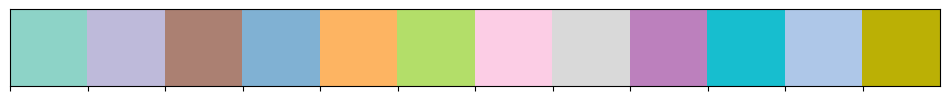

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a custom color palette to remove the very light/invisible green from Set3 palette
custom_palette = [
    '#8dd3c7',
    '#bebada',
    '#ab8072',
    '#80b1d3',
    '#fdb462',
    '#b3de69',
    '#fccde5',
    '#d9d9d9',
    '#bc80bd',
    '#17becf',
    '#aec7e8',
    '#bbb005']

sns.palplot(custom_palette)
plt.show()

Function for creating bar plots of Features (Restaurant Features) vs. Labels (Restaurant Type):

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

label_col = 'label'
feature_cols = [
    'attributes.OutdoorSeating',
    'attributes.BusinessAcceptsCreditCards',
    'attributes.RestaurantsTableService',
    'attributes.RestaurantsReservations',
    'attributes.RestaurantsPriceRange2',
    'attributes.WiFi',
    'attributes.NoiseLevel',
    'state',
    'attributes.Alcohol',
    'attributes.HasTV',
    'attributes.RestaurantsGoodForGroups',
    'attributes.Caters',
    'attributes.RestaurantsTakeOut',
    'attributes.RestaurantsAttire',
    'attributes.RestaurantsDelivery',
    'attributes.GoodForKids',
    'attributes.BusinessAcceptsBitcoin'
]

# In case want to view unknowns
df_plot = df_train.copy()
df_plot[feature_cols] = df_plot[feature_cols].replace('', 'Unknown').fillna("Unknown")
df_plot[label_col] = df_plot[label_col].replace('', 'Unknown').fillna("Unknown")

# Plotting function
def plot_categorical_barplots(
    data,
    features,
    x_axis='feature',
    hue_axis='label',
    percentage=False,
    drop_unknown=False,
    title_suffix=""
):
    n_cols = 3
    n_rows = -(-len(features) // n_cols)  # ceiling division
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()
    custom_palette = [
    '#8dd3c7',
    '#bebada',
    '#ab8072',
    '#80b1d3',
    '#fdb462',
    '#b3de69',
    '#fccde5',
    '#d9d9d9',
    '#bc80bd',
    '#17becf',
    '#aec7e8',
    '#bbb005']

# sns.palplot(custom_palette)
# plt.show()

    for i, col in enumerate(features):
        ax = axes[i]

        x_col = col if x_axis == 'feature' else label_col
        hue_col = label_col if x_axis == 'feature' else col

        plot_data = data.copy()
        if drop_unknown:
            plot_data = plot_data[
                (plot_data[x_col] != 'Unknown') & (plot_data[hue_col] != 'Unknown')
            ]

        # Build custom palette
        unique_values = plot_data[hue_col].unique()
        has_false = 'False' in unique_values

        if has_false:
            palette = {'False': 'gray'} #gray for Falses
            other_values = sorted([val for val in unique_values if val != 'False'])
            other_colors = sns.color_palette('Set2', len(other_values))
            palette.update({val: color for val, color in zip(other_values, other_colors)})

        else: #custom palette
            other_values = sorted(unique_values)
            if len(other_values) > len(custom_palette):
                raise ValueError("Not enough colors in custom_palette for the number of unique values.")
            palette = {val: custom_palette[i] for i, val in enumerate(other_values)}


        if percentage: #for % of total (vs. count)
            count_df = plot_data.groupby([x_col, hue_col]).size().reset_index(name='count')
            total_per_x = count_df.groupby(x_col)['count'].transform('sum')
            count_df['percent'] = (count_df['count'] / total_per_x) * 100

            sns.barplot(
                data=count_df,
                x=x_col,
                y='percent',
                hue=hue_col,
                palette=palette,
                ax=ax
            )
            ax.set_ylabel('Percent (%)')
        else: # by raw counts
            sns.countplot(
                data=plot_data,
                x=x_col,
                hue=hue_col,
                palette=palette,
                ax=ax
            )
            ax.set_ylabel('Count')

        ax.set_title(f"{col.replace('attributes.', '').replace('_', ' ')} {title_suffix}", fontsize=11)
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=30)
        ax.legend(title=hue_col, fontsize=8)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


Bar Plots by Feature color-coded by Label in term of raw counts to see volume:

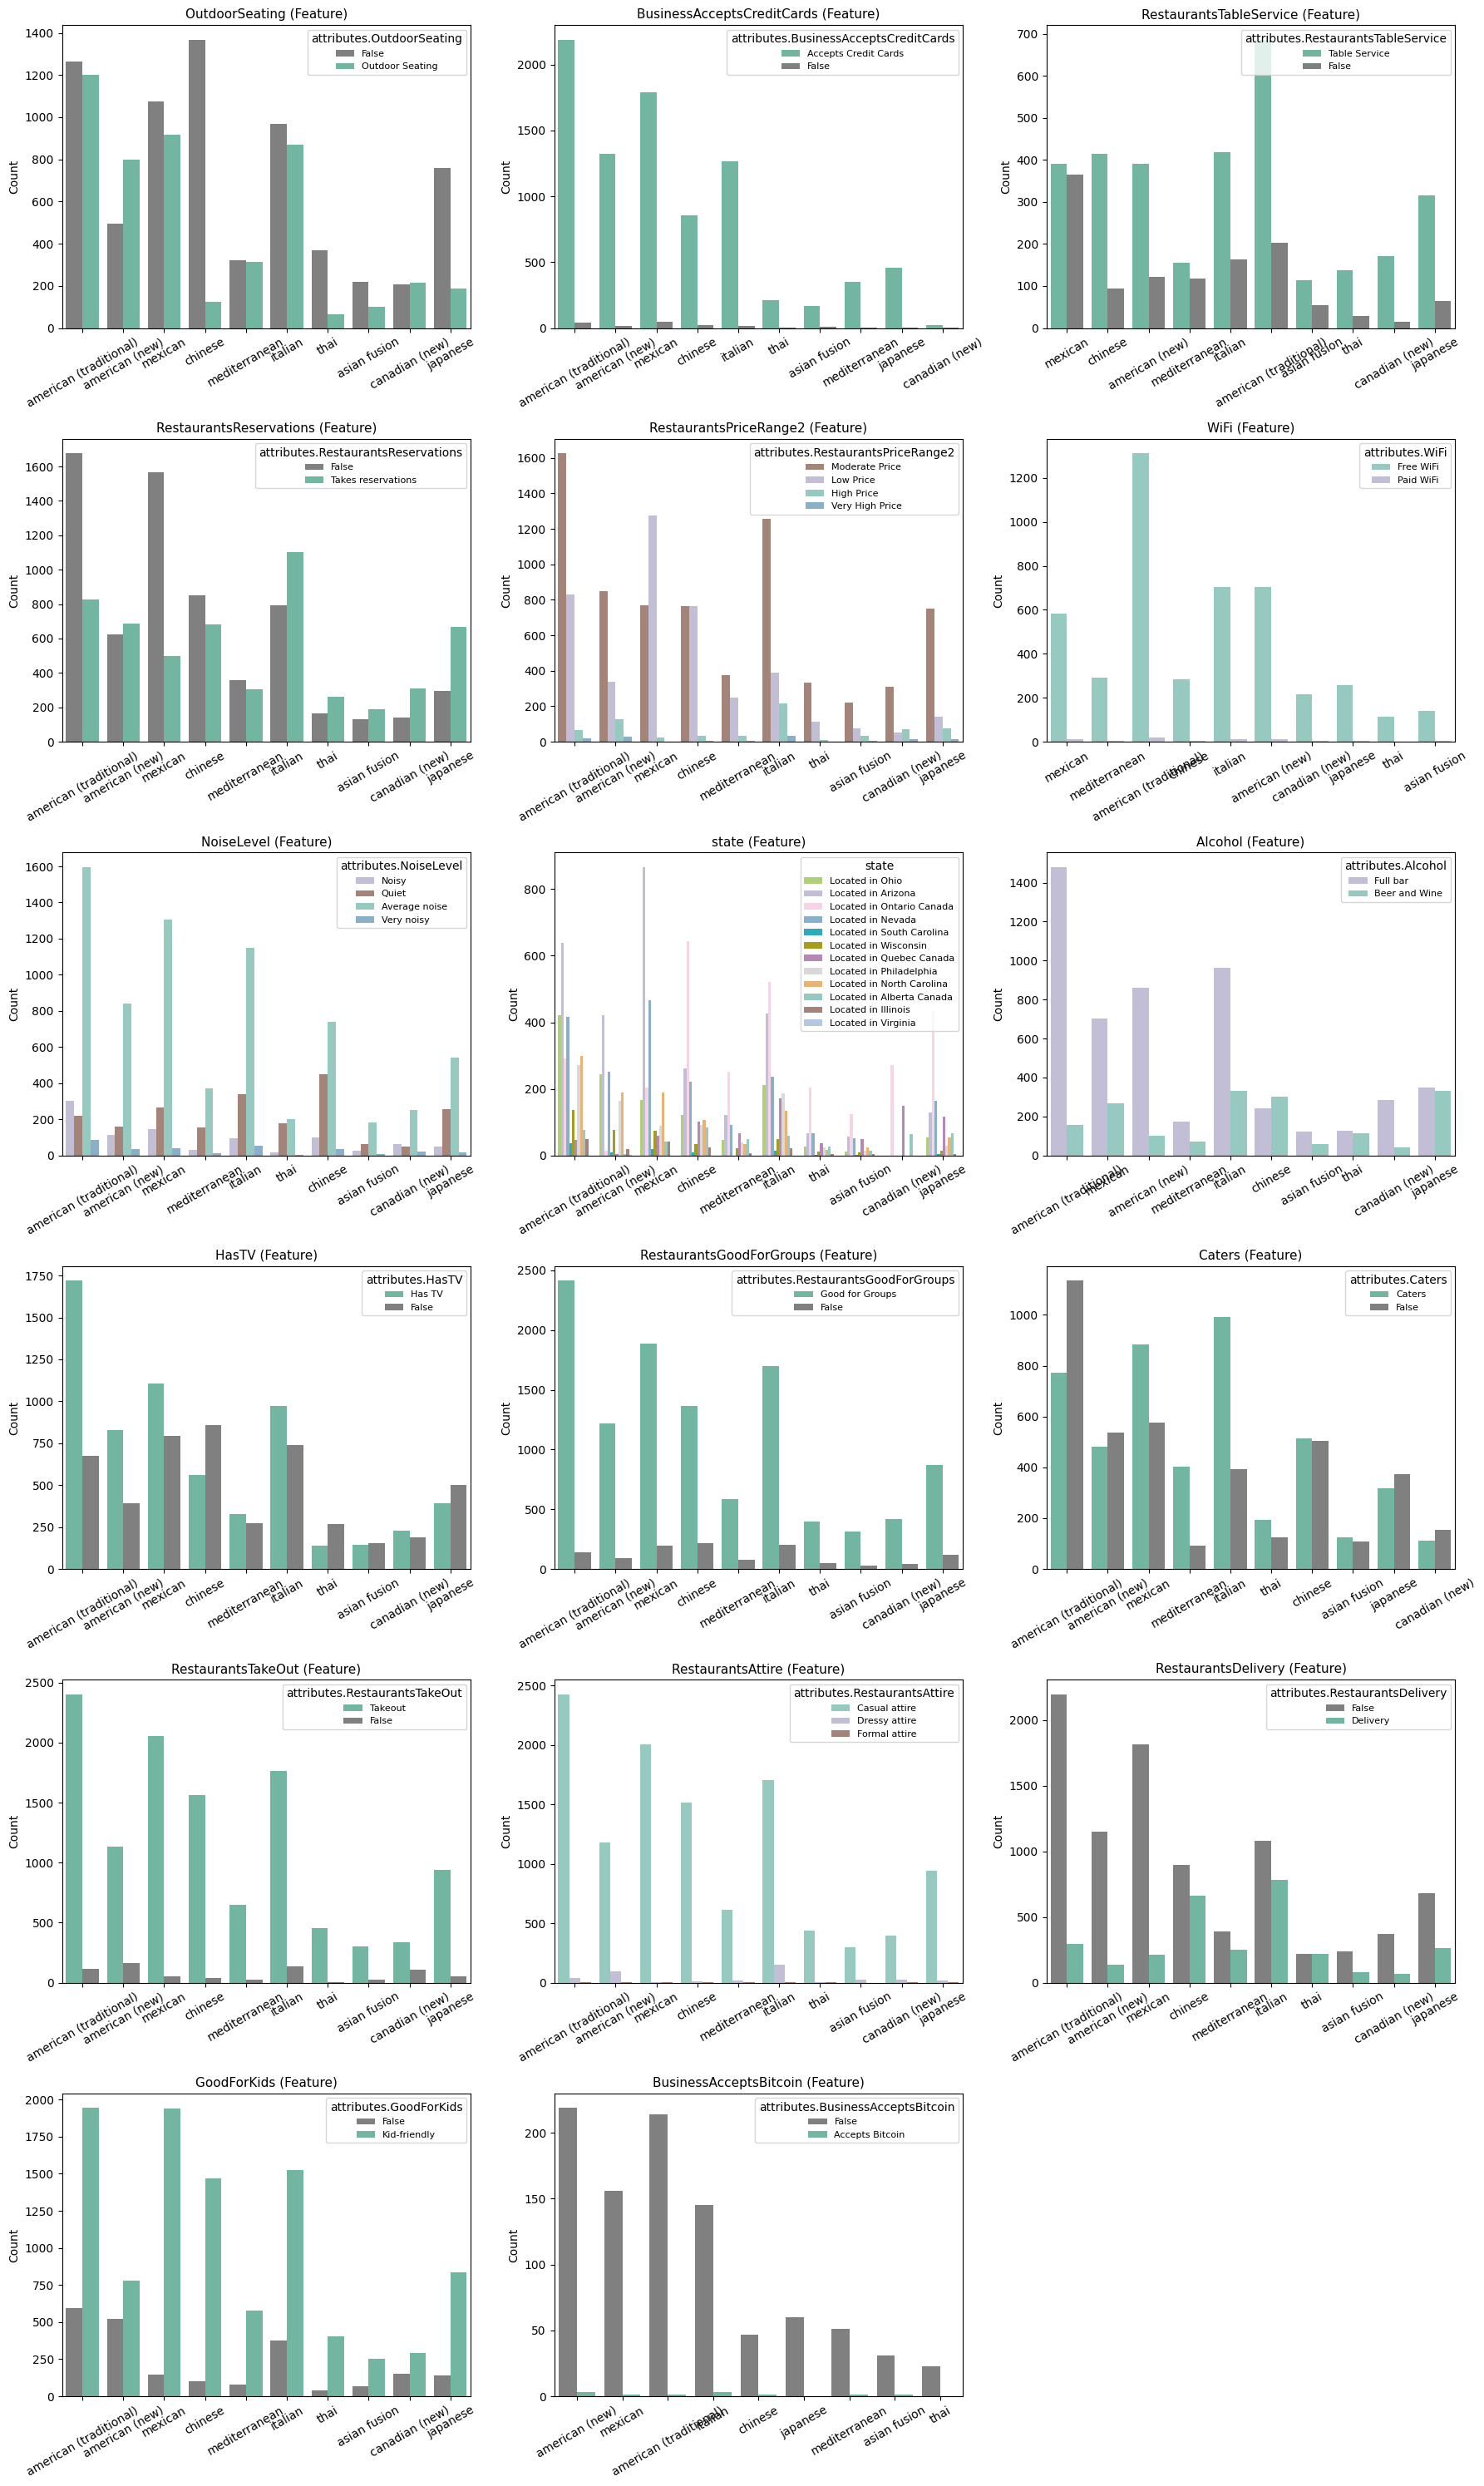

In [ ]:
#Count
plot_categorical_barplots(
    df_plot,
    features=feature_cols,
    x_axis='label',
    hue_axis='feature',
    percentage=False,
    # palette="Set2",
    drop_unknown=True,
    title_suffix='(Feature)'
)

Bar Plots by Feature and Label in terms of % of Total:

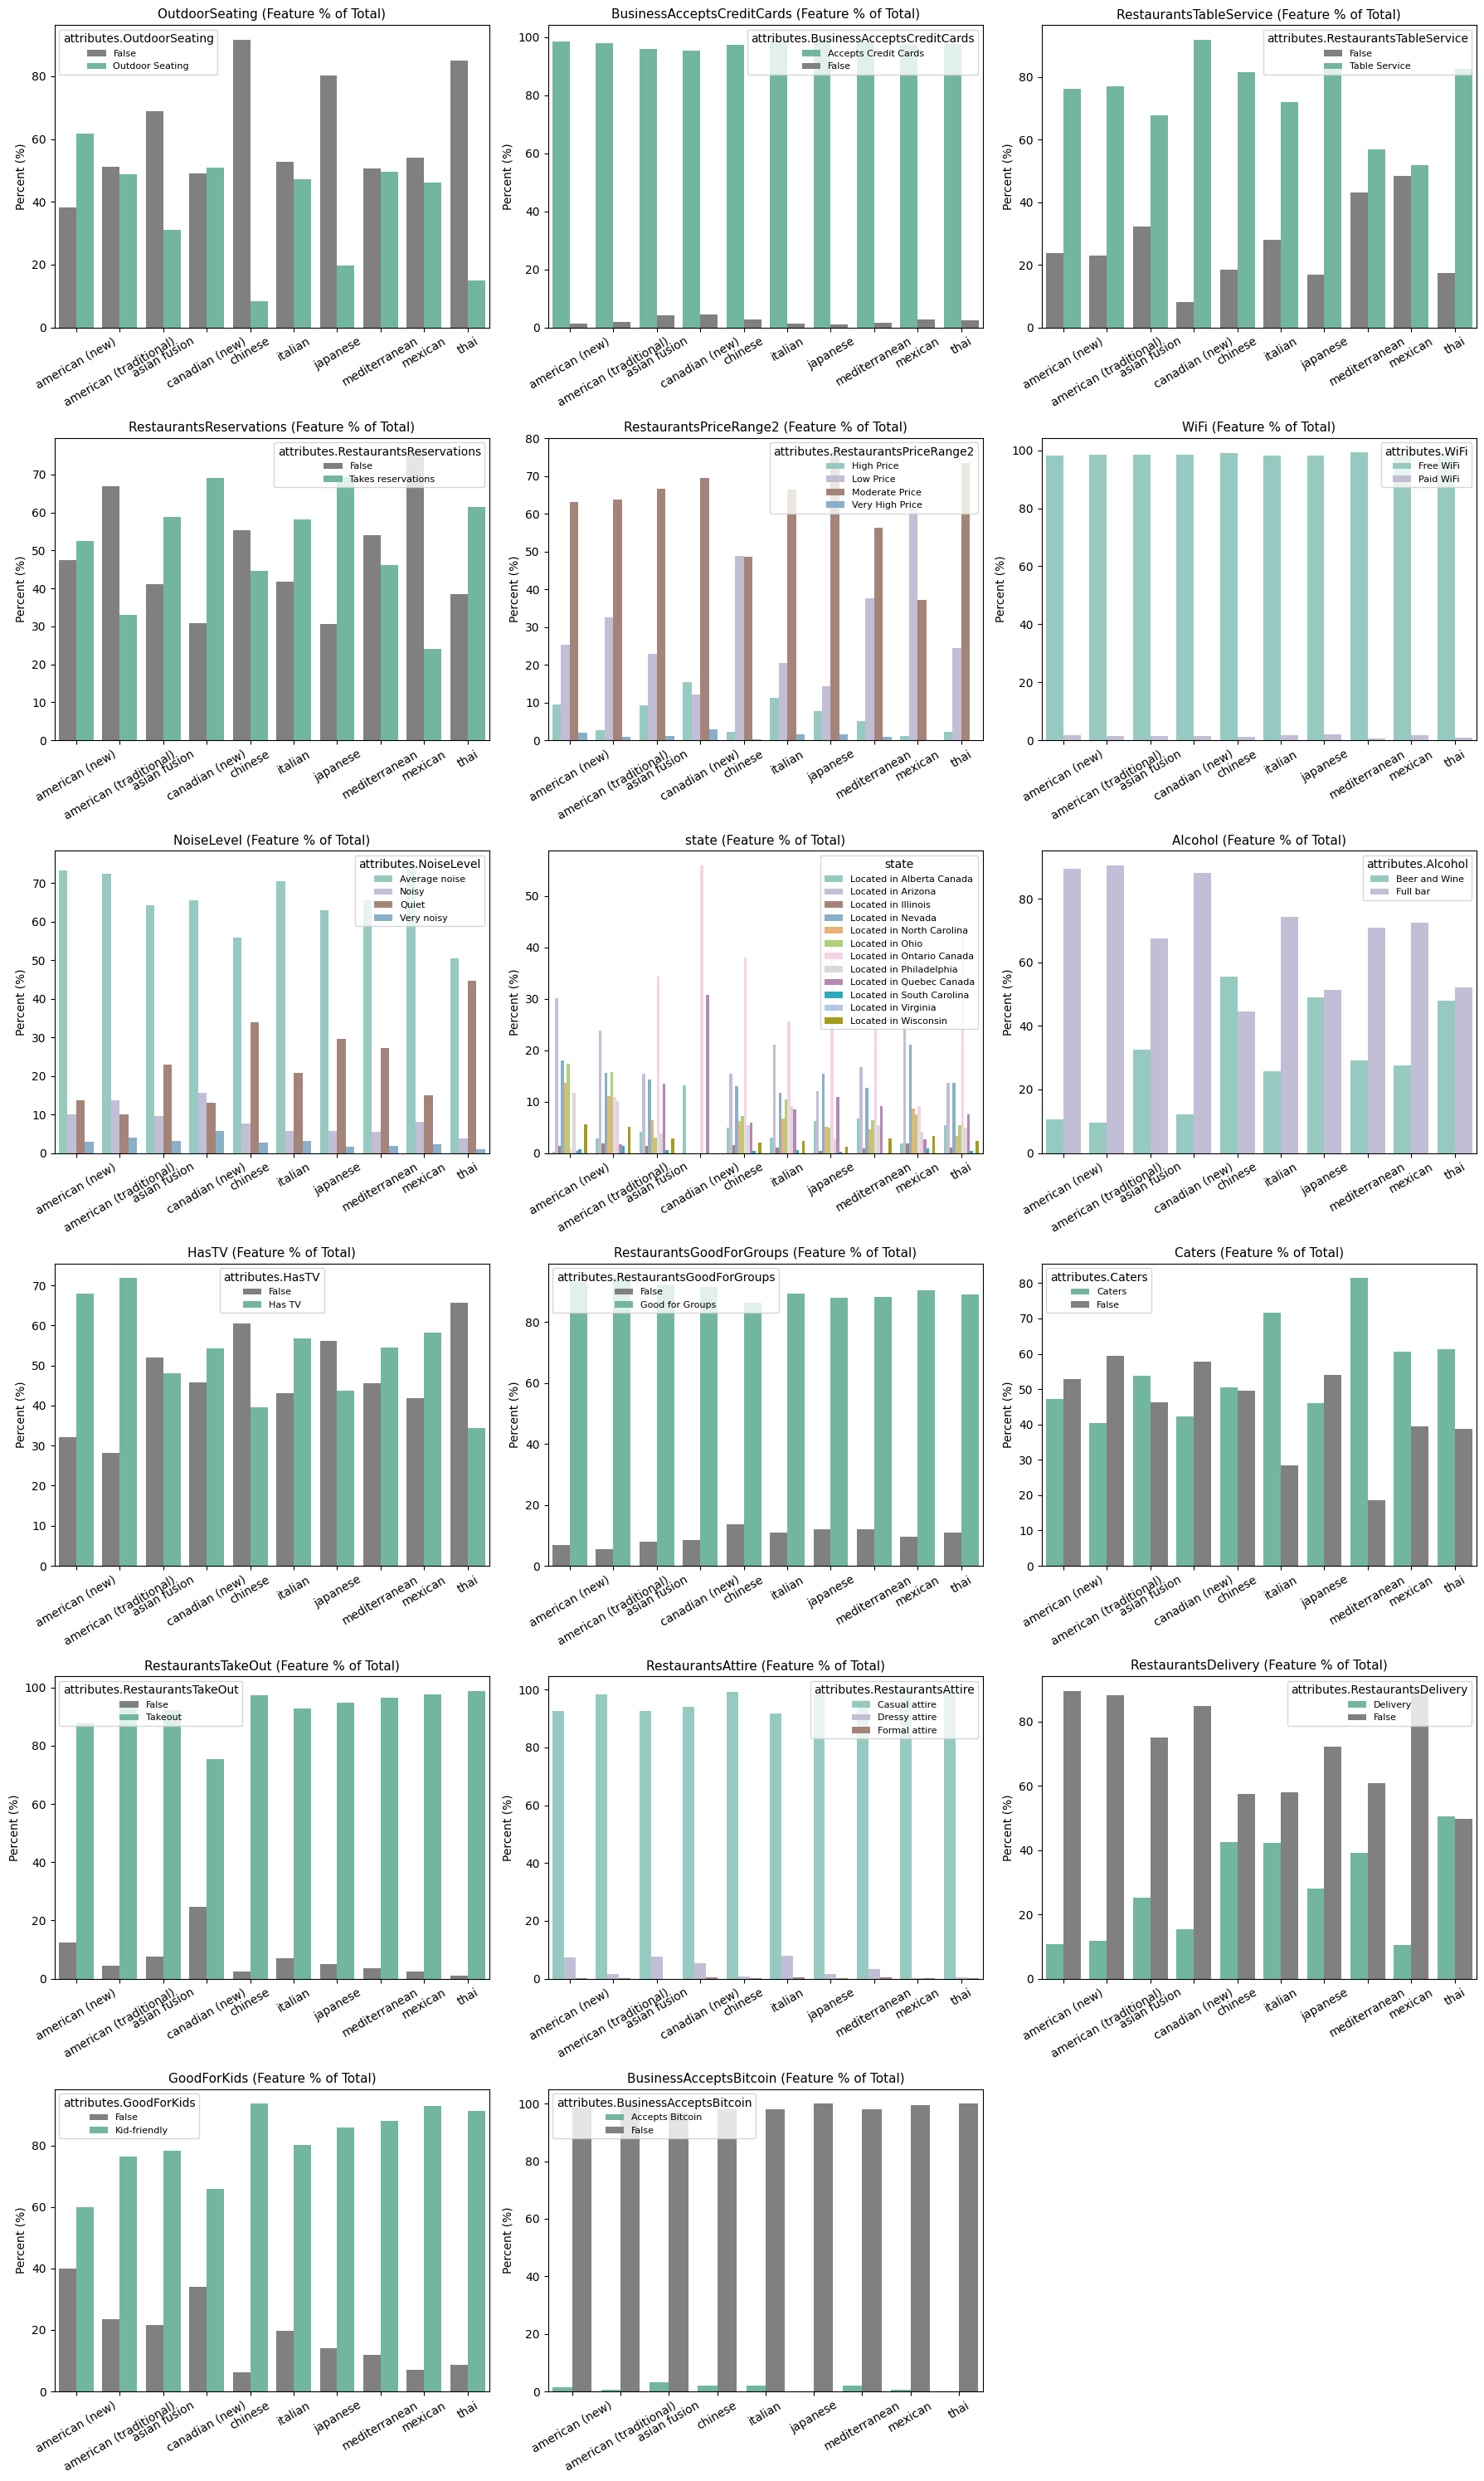

In [ ]:

# Percent of Total (excluding unknowns)
plot_categorical_barplots(
    df_plot,
    features=feature_cols,
    x_axis='label',
    hue_axis='feature',
    percentage=True,
    # palette="Set2",
    drop_unknown=True,
    title_suffix='(Feature % of Total)'
)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Chi-Squared%20Tests.png)

Perform chi-squared to isolate most relvant features in predicting Restaurant Type. This isn't an exact science because NLP uses word embeddings and the words of the feature are important in relation to other words, not in isolation, so this just to get some good guesses at what might help to include:

Make a copy of the dataframe for the chi-squared to make sure to keep df_train intact:

In [ ]:
df_train_chi=df_train.copy()
df_train_chi.columns

Index(['attributes.Ambience', 'attributes.OutdoorSeating', 'name',
       'attributes.BusinessAcceptsCreditCards',
       'attributes.RestaurantsTableService',
       'attributes.RestaurantsReservations',
       'attributes.RestaurantsPriceRange2', 'attributes.WiFi',
       'attributes.NoiseLevel', 'state', 'attributes.Alcohol',
       'attributes.HasTV', 'attributes.RestaurantsGoodForGroups',
       'attributes.Caters', 'attributes.RestaurantsTakeOut',
       'attributes.RestaurantsAttire', 'attributes.RestaurantsDelivery',
       'attributes.GoodForKids', 'attributes.GoodForMeal', 'label', 'review',
       'attributes.BusinessAcceptsBitcoin', 'text'],
      dtype='object')

Ambience, Business Parking, Name, and Good For Meal would be too lengthy for contingency tables, so making a new df for the chi-squared that excludes those:

In [ ]:
df_train_chi = df_train.drop(['attributes.Ambience','name', 'review', 'text', 'attributes.GoodForMeal'], axis=1)

Run chi-squared test of features vs. label as a whole:

For each feature, it tests whether the distribution of that feature differs across all classes (i.e., is dependent on the label).

High chi-squared -> feature distribution is very different across labels → good at distinguishing between multiple classes.

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

features = [col for col in df_train_chi.columns if col != 'label']

results = []

# If current feature has 'Unknown' -> row is excluded
for feature in features:
    filtered_df = df_train_chi[
        (df_train_chi[feature] != '')
    ]

    if filtered_df.empty:
        print(f"Skipping {feature}: no data after dropping 'Unknown'")
        continue

    contingency_table = pd.crosstab(filtered_df[feature], filtered_df['label'])

    #INCLUDED FOR DOUBLE-CHECK
    #ON TEST FEATURE OUTDOOR SEATING vs. google sheet https://docs.google.com/spreadsheets/d/1hgWeBnjwlCPP1luDLoGsbTfCB5b4L0DW5AH1NMxkH88/edit?gid=0#gid=0

    # print(contingency_table)
    # observed = contingency_table.values
    # row_totals = observed.sum(axis=1, keepdims=True)
    # col_totals = observed.sum(axis=0, keepdims=True)
    # grand_total = observed.sum()
    # print(observed)
    # print(row_totals)
    # print(col_totals)
    # print(grand_total)
    # expected = row_totals @ col_totals / grand_total
    # print(expected)
    # chi2, p, dof, expected = chi2_contingency(contingency_table)
    # print(f"Chi2 statistic: {chi2:.2f}")
    # print(f"Degrees of freedom: {dof}")
    # print(f"P-value: {p:.4f}")
    # if p < 0.05:
    #     print("✅ Significant association (reject H0)")
    # else:
    #     print("❌ No significant association (fail to reject H0)")

    if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        print(f"Skipping {feature}: not enough categories for chi-squared test")
        continue

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    results.append({
        'feature': feature,
        'chi2_stat': chi2,
        'p_value': p,
        'dof': dof,
        'significant': p < 0.05
    })

chi_squared_df = pd.DataFrame(results)

# Rank by p-value ascending (most significant first)
chi_squared_df = chi_squared_df.sort_values(by='p_value').reset_index(drop=True)

print(chi_squared_df)


                                  feature    chi2_stat        p_value  dof  \
0                                   state  3939.039246   0.000000e+00   99   
1       attributes.RestaurantsPriceRange2  1665.106313   0.000000e+00   27   
2          attributes.RestaurantsDelivery  1399.711708  8.923282e-296    9   
3               attributes.OutdoorSeating  1350.616909  3.606878e-285    9   
4      attributes.RestaurantsReservations  1072.411491  4.155834e-225    9   
5                  attributes.GoodForKids   924.241972  3.695738e-193    9   
6                      attributes.Alcohol   895.661060  5.325074e-187    9   
7                   attributes.NoiseLevel   706.886833  1.373822e-131   27   
8                        attributes.HasTV   613.866240  2.211123e-126    9   
9                       attributes.Caters   551.927725  4.298122e-113    9   
10          attributes.RestaurantsTakeOut   505.328328  4.155660e-103    9   
11           attributes.RestaurantsAttire   370.316653   1.38247

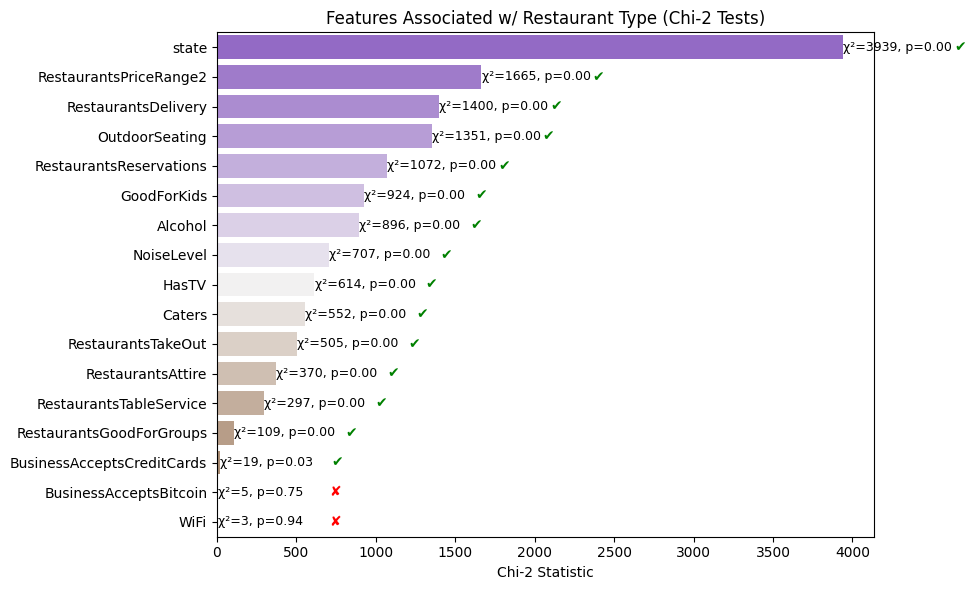

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Clean feature names
chi_squared_df['feature'] = chi_squared_df['feature'].str.replace('attributes.', '', regex=False)

# Set up figure and palette
plt.figure(figsize=(10, 6))
palette = sns.diverging_palette(280, 40, s=70, l=50, n=len(chi_squared_df), as_cmap=False)

# Create barplot and store the axis
ax = sns.barplot(
    data=chi_squared_df,
    x='chi2_stat',
    y='feature',
    hue='feature',
    palette=palette,
    legend=False
)

# Annotate bars
for i, row in chi_squared_df.iterrows():
    stat = f"χ²={row['chi2_stat']:.0f}"
    p = f"p={row['p_value']:.2f}"
    sig_symbol = '✔' if row['significant'] else '✘'
    sig_color = 'green' if row['significant'] else 'red'

    # Write stat and p-value
    ax.text(
        row['chi2_stat'] + 0.5,
        i,
        f"{stat}, {p} ",
        va='center',
        ha='left',
        fontsize=9,
        color='black'
    )

    # Write check or x separately so it can be colored
    ax.text(
        row['chi2_stat'] + 0.5 + 700,  # space it out to the right
        i,
        sig_symbol,
        va='center',
        ha='left',
        fontsize=10,
        color=sig_color,
        fontweight='bold'
    )

# Labels and layout
plt.title('Features Associated w/ Restaurant Type (Chi-2 Tests)')
plt.xlabel('Chi-2 Statistic')
plt.ylabel('')
plt.tight_layout()
plt.show()


For each class (Restaurant type) individually, tests whether the feature distinguishes that class vs all others (for optimization of individual class prediction if one or more in particular aren't performing well):

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

features = [col for col in df_train_chi.columns if col != 'label']
unique_classes = df_train_chi['label'].dropna().unique()

all_results = []

for class_label in unique_classes:

    # Binary label: 1 if class_label, 0 otherwise
    df_binary = df_train_chi.copy()
    df_binary['binary_label'] = df_binary['label'].apply(lambda x: 1 if x == class_label else 0)

    for feature in features:
        # Clean data
        filtered_df = df_binary[
            (df_binary[feature] != '') & (df_binary[feature] != ' ') &
            (df_binary[feature].notna())
        ]

        if filtered_df.empty:
            continue

        # Create contingency table
        contingency = pd.crosstab(filtered_df[feature], filtered_df['binary_label'])

        if contingency.shape[0] < 2 or contingency.shape[1] < 2:
            continue

        chi2, p, dof, expected = chi2_contingency(contingency)

        all_results.append({
            'class': class_label,
            'feature': feature,
            'chi2_stat': chi2,
            'p_value': p,
            'dof': dof,
            'significant': p < 0.05
        })

# Convert to DataFrame and sort
chi_squared_by_class_df = pd.DataFrame(all_results)
chi_squared_by_class_df = chi_squared_by_class_df.sort_values(['class', 'p_value']).reset_index(drop=True)

# # Show top results per class
# print(chi_squared_by_class_df)


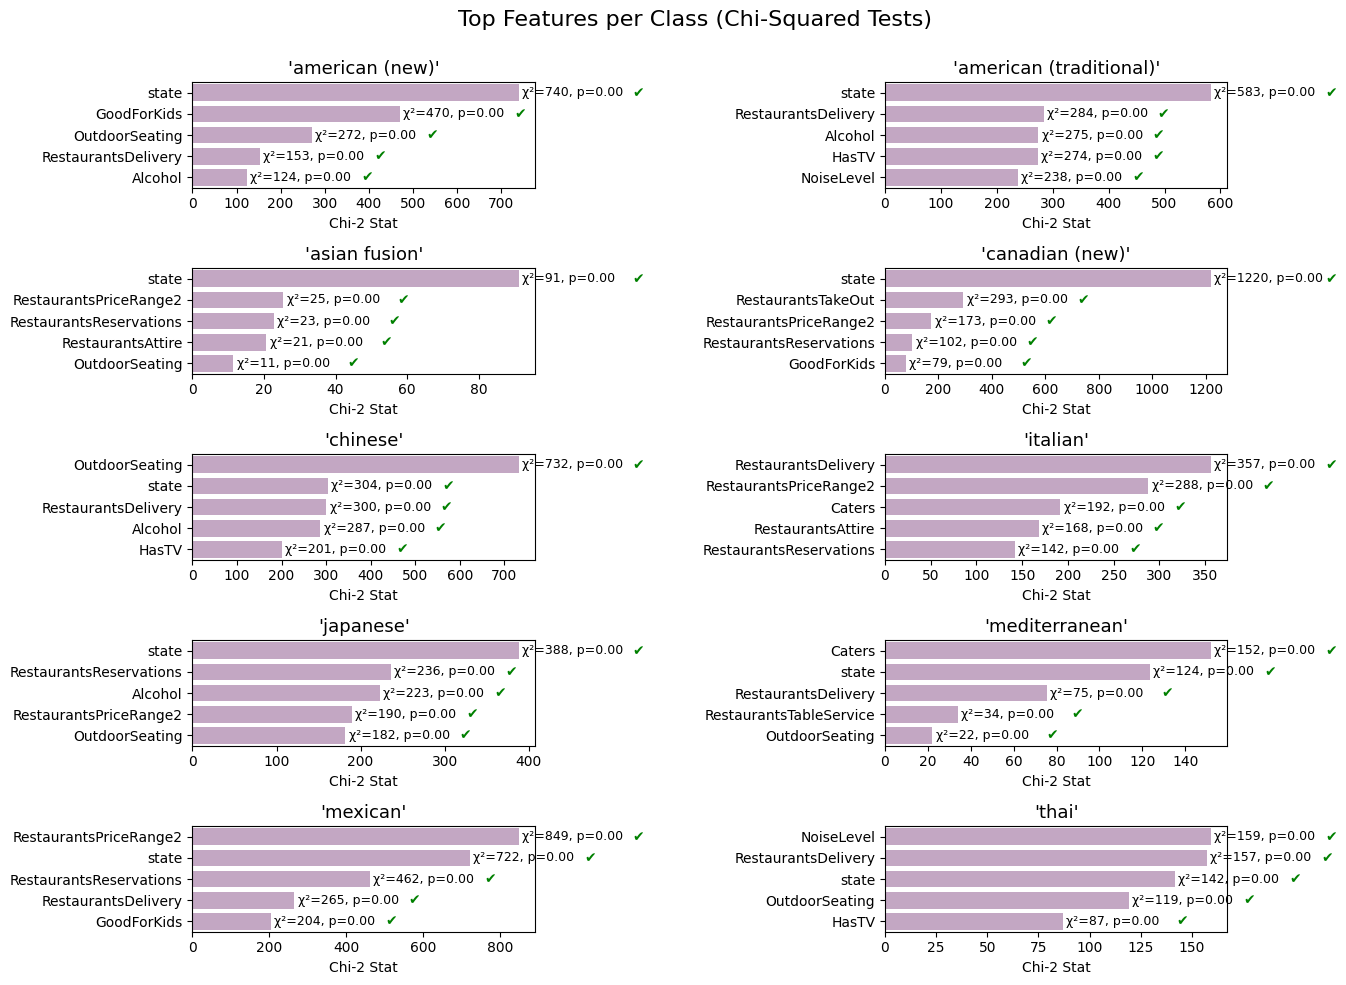

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Clean feature names
chi_squared_by_class_df['feature'] = chi_squared_by_class_df['feature'].str.replace('attributes.', '', regex=False)

# Select top 5 features per class by lowest p-value
top_features_df = (
    chi_squared_by_class_df
    .sort_values(['class', 'p_value'])
    .groupby('class')
    .head(5)
    .reset_index(drop=True)
)

# Get sorted list of unique classes
classes = sorted(top_features_df['class'].unique())
n_classes = len(classes)
n_cols = 2
n_rows = math.ceil(n_classes / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 2 * n_rows))
axes = axes.flatten()  # flatten to 1D for easy indexing

for idx, class_label in enumerate(classes):
    ax = axes[idx]
    class_df = top_features_df[top_features_df['class'] == class_label].copy()

    class_df = class_df.sort_values("chi2_stat", ascending=False)

    # palette = sns.diverging_palette(280, 40, s=70, l=50, n=len(class_df), as_cmap=False)
    lilac = "#C8A2C8"  # hex for a soft lilac tone
    palette = [lilac] * len(class_df)

    sns.barplot(
        data=class_df,
        x='chi2_stat',
        y='feature',
        hue='feature',
        palette=palette,
        legend=False,
        ax=ax
    )

    offset = class_df['chi2_stat'].max() * 0.01

    for i, (index, row) in enumerate(class_df.iterrows()):
        stat = f"χ²={row['chi2_stat']:.0f}"
        pval = f"p={row['p_value']:.2f}"
        sig_symbol = '✔' if row['significant'] else '✘'
        sig_color = 'green' if row['significant'] else 'red'

        xpos = row['chi2_stat'] + offset

        ax.text(
            xpos,
            i,
            f"{stat}, {pval}",
            va='center',
            ha='left',
            fontsize=9,
            color='black'
        )

        ax.text(
            xpos + offset * 34,
            i,
            sig_symbol,
            va='center',
            ha='left',
            fontsize=10,
            color=sig_color,
            fontweight='bold'
        )

    ax.set_title(f"'{class_label}'", fontsize=13)
    ax.set_xlabel("Chi-2 Stat")
    ax.set_ylabel("")

# Remove any unused subplots (if class count isn't even)
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Top Features per Class (Chi-Squared Tests)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Finalize%20Data.png)

Final Edit: Filter out "False" for use in models:

In [ ]:
for col in df_train.columns:
    if col.startswith("attributes.") and col not in ["attributes.GoodForMeal", "attributes.Ambience"]:
        print(f"\nColumn: {col}")

        # Replace string "False" with NaN
        df_train[col] = df_train[col].replace("False", pd.NA)

        unique_vals = df_train[col].dropna().astype(str)
        print(unique_vals.unique().tolist())



Column: attributes.OutdoorSeating
['Outdoor Seating', '']

Column: attributes.BusinessAcceptsCreditCards
['Accepts Credit Cards', '']

Column: attributes.RestaurantsTableService
['', 'Table Service']

Column: attributes.RestaurantsReservations
['Takes reservations', '']

Column: attributes.RestaurantsPriceRange2
['Moderate Price', '', 'Low Price', 'High Price', 'Very High Price']

Column: attributes.WiFi
['', 'Free WiFi', 'Paid WiFi']

Column: attributes.NoiseLevel
['Noisy', 'Quiet', '', 'Average noise', 'Very noisy']

Column: attributes.Alcohol
['Full bar', '', 'Beer and Wine']

Column: attributes.HasTV
['Has TV', '']

Column: attributes.RestaurantsGoodForGroups
['Good for Groups', '']

Column: attributes.Caters
['Caters', '']

Column: attributes.RestaurantsTakeOut
['Takeout', '']

Column: attributes.RestaurantsAttire
['Casual attire', '', 'Dressy attire', 'Formal attire']

Column: attributes.RestaurantsDelivery
['', 'Delivery']

Column: attributes.GoodForKids
['Kid-friendly', '']

C

#Dimension Reduction

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Dimension%20Reduction.png)

Drop additional features:

*   review was renamed to 'text' since the field is labeled 'text' in the tokenizing function later
*   wifi  - removed per chi-squared
*   accepts bitcoin - removed per chi-squared
*   accepts credit cards - removed per individual class chi-squareds (not at top)
*   good for groups - removed per EDA charts (distributions not that different) and chi-squared

I tested a handful of combinations (did not have the compute resources to do this super thoroughly).

In [ ]:
columns_to_drop = [
                  # 'name',
                  # 'state',
                  'review', #bc renamed to 'text'
                  # 'attributes.RestaurantsTableService',
                  # 'attributes.RestaurantsAttire',
                  # 'attributes.RestaurantsDelivery',
                  # 'attributes.GoodForKids',
                  # 'attributes.GoodForMeal'
                  'attributes.RestaurantsGoodForGroups',
                  # 'attributes.HasTV',
                  'attributes.BusinessAcceptsBitcoin',
                  # 'attributes.RestaurantsTakeOut',
                  # 'attributes.Ambience',
                  # 'attributes.OutdoorSeating',
                  'attributes.BusinessAcceptsCreditCards',
                  # 'attributes.RestaurantsReservations',
                  # 'attributes.RestaurantsPriceRange2',
                  'attributes.WiFi',
                  # 'attributes.NoiseLevel',
                  # 'attributes.Alcohol',
                  # 'attributes.Caters'
                  ]

df_train = df_train.drop(columns_to_drop, axis=1)
df_test = df_test.drop(columns_to_drop, axis=1)

In [ ]:
df_train.columns

Index(['attributes.Ambience', 'attributes.OutdoorSeating', 'name',
       'attributes.RestaurantsTableService',
       'attributes.RestaurantsReservations',
       'attributes.RestaurantsPriceRange2', 'attributes.NoiseLevel', 'state',
       'attributes.Alcohol', 'attributes.HasTV', 'attributes.Caters',
       'attributes.RestaurantsTakeOut', 'attributes.RestaurantsAttire',
       'attributes.RestaurantsDelivery', 'attributes.GoodForKids',
       'attributes.GoodForMeal', 'label', 'text'],
      dtype='object')

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Concatenating%20Features.png)

This is the finalization of the data that will go into the model. The restaurant review (called 'text' in the data) starts as the primary source of what would be used in the model to predict restaurant type. All of these other features I have formatted and included are additional to that data and were added to supplement it, so I wanted them to be as succinct and meaningful as possible. The model is essentially predicting from the 'review + other features' to predict the type. The method here to get the single field of data to input into the natural language model is to concatenate the words of the additional features to the review to create one long piece of text. Note using a separator between the features (a period here) is helpful for the model to compartmentalize unrelated text.

View restaurant reviews field separately first before concatenating with other features:

Example of "text" value (restaurant reviews for one restaurant) before adding features to it:

In [ ]:
print(df_train['text'].iloc[0])

So, we stopped here on our way to the Side Quest, which is just up the street. \n\nWe did not know what to expect, but came on a 3$ taco night...\n\nIm so glad we did:)\n\nMostly, the Rush Inn is a bar-ish place, but theres plenty of back and side seating at booths all through. The place has a dark, rich wood tone, and the patrons were decent folks.\n\nThe tacos were EXCEPTIONAL, and their selection is quite good, with all sorts of stuff I intend to try as soon as possible. I think this place would make a nice casual dinner/lunch stop, and if you need to get beverage, the barkeep and wait staff will keep em coming! \n\nSo, for a quick tasty bite, dont walk slow, RUSH IN TO THE RUSH INN! My boyfriend and I heard about this little place near Rush Inn that offered board games and poutine on Friday. When we arrived, they didnt have food because the chef didnt show up (?) so we ventured to this place a block down. Great vibe inside. A typical bar scene, but had great booze selections and a 

Concatenate 'text' (review) field with other features:

In [ ]:
# Get all column names except 'label'
fields_to_concat = [col for col in df_train.columns if col != 'label']

# Concatenate with periods between values
df_train["concatenated"] = df_train[fields_to_concat]\
    .fillna("").astype(str)\
    .apply(lambda row: ".".join(row.values), axis=1)


In [ ]:
# Ensure all fields are strings and fill NaNs with empty string
df_train[fields_to_concat] = df_train[fields_to_concat].fillna('').astype(str)

# Concatenate only non-empty fields, separated by '. '
df_train["text_review_and_features"] = df_train[fields_to_concat].apply(
    lambda row: '. '.join([val for val in row if val.strip() != '']),
    axis=1
)


In [ ]:
# Ensure all fields are strings and fill NaNs with empty string
df_test[fields_to_concat] = df_test[fields_to_concat].fillna('').astype(str)

# Concatenate only non-empty fields, separated by '. '
df_test["text_review_and_features"] = df_test[fields_to_concat].apply(
    lambda row: '. '.join([val for val in row if val.strip() != '']),
    axis=1
)


This is the final text field that will be fed into the natural language model. It is a concatenation of features (as text) joined to the restaurant review text, which will be used as one big text field to predict the restaurant type:

One example of new "text" value (restaurant reviews + additional features):

In [ ]:
print(df_train['text_review_and_features'].iloc[0])

casual. Restaurant named Rush Inn. Moderate Price. Noisy. Located in Ohio. Full bar. Has TV. Caters. Takeout. Casual attire. Good for lunch, Good for dinner. So, we stopped here on our way to the Side Quest, which is just up the street. \n\nWe did not know what to expect, but came on a 3$ taco night...\n\nIm so glad we did:)\n\nMostly, the Rush Inn is a bar-ish place, but theres plenty of back and side seating at booths all through. The place has a dark, rich wood tone, and the patrons were decent folks.\n\nThe tacos were EXCEPTIONAL, and their selection is quite good, with all sorts of stuff I intend to try as soon as possible. I think this place would make a nice casual dinner/lunch stop, and if you need to get beverage, the barkeep and wait staff will keep em coming! \n\nSo, for a quick tasty bite, dont walk slow, RUSH IN TO THE RUSH INN! My boyfriend and I heard about this little place near Rush Inn that offered board games and poutine on Friday. When we arrived, they didnt have fo

In [ ]:
print(df_test['text_review_and_features'].iloc[0])

Outdoor Seating. Restaurant named Fuse. Takes reservations. Moderate Price. Located in Ontario Canada. Full bar. Has TV. False. Takeout. Casual attire. False. False. Overall wonderful experience. \n\nThe owner Farley Flex came by and paid our table a visit. Staff are very friendly, helpful and service was quick given we were a table of 12. \n\nThe restaurant has a very relaxed/soulful vibe; beautiful artwork on the walls and live entertainment every weekend starting in June (I will be going back for that).\n\nNo complaints! Fav spot close to home and the escovich tacos are to die for!! Great atmosphere but on the pricey side... The music is incredible, the food is great, if a bit salty, the service is sweet. \n\nThe service is the drawback. No recommendations for the new restaurant because they havent tried it yet. Not sure whats available for beer/wine and gone for 3-4 minutes to get a drink menu. Make no mistake, service will get better, and food is worth the visit. \nSo is the music

#Average Embedding Models

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Average%20Embedding%20Models.png)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Load%20Libraries.png)

Load libraries for Average Embedding Models:

In [ ]:
import pickle
import pandas as pd
import itertools
from collections import Counter
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import word2vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import os
import string


# NLTK library downloads
nltk.download('stopwords')
nltk.download('punkt_tab')

##Data Pre-Processing

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Data%20Pre-Processing.png)

Data Pre-Processing for Average Word Embeddings:


1.   TEXT PRE-PROCESSING | pre-process_df: Clean the data of stopwords, punctuation and single character words
2.   TOKENIZATION | tokenize_text_column: Tokenize the Training and Test Data sentences (with nltk tokenizer)
3.   BUILD VOCABULARY | build_vocab: Build vocabulary from Tokenized Data
4.   inp_data: Create Input Data (indices only) to build sentences of indices of words using Vocabulary and Tokenized Data
5.   WORD EMBEDDINGS | get_embeddings: Train Word2Vec Skigram model to get word embedding weights matrix (W) using Vocabulary and Input Data
6.   AVERAGE EMBEDDING VECTORS | average_embedding_vectors: Build Avg. Word Embedding Vectors for training and test sets (1 vector for each restaurant's review field/set of reviews)



![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Functions.png)

Functions for Steps:

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Text%20Pre-Processing.png)

Function to pre-process raw (English) text:

In [ ]:
def preprocess_df(df):
    # get English stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    preprocessed_sentences = []
    for i, row in df.iterrows():
        sent = row["text"]
        sent_nopuncts = sent.translate(translator)
        words_list = sent_nopuncts.strip().split()
        filtered_words = [word for word in words_list if word not in stop_words and len(word) != 1]
        preprocessed_sentences.append(" ".join(filtered_words))
    df["text"] = preprocessed_sentences
    return df

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Build%20Vocabulary.png)

Function to build a vocabulary based on descending word frequencies:

In [ ]:
def build_vocab(sentences):
    word_counts = Counter(itertools.chain(*sentences))
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return word_counts, vocabulary, vocabulary_inv

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Word%20Embeddings.png)

Function to learn word embeddings through Word2vec module and skigram (builds matrix W):

In [ ]:

def get_embeddings(inp_data, vocabulary_inv, size_features=100, #100 features originally
                   mode='skipgram',
                   min_word_count=2, #2 originally
                   context=5): #5 originally
    model_name = "embedding"
    model_name = os.path.join(model_name)
    num_workers = 15  #15 originally
    downsampling = 1e-3  # Downsample setting for frequent words
    print('Training Word2Vec model...')
    sentences = [[vocabulary_inv[w] for w in s] for s in inp_data]
    if mode == 'skipgram':
        sg = 1
        print('Model: skip-gram')
    elif mode == 'cbow':
        sg = 0
        print('Model: CBOW')
    embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                        sg=sg,
                                        vector_size=size_features,
                                        min_count=min_word_count,
                                        window=context,
                                        sample=downsampling,
                                        seed=42)
    print("Saving Word2Vec model {}".format(model_name))
    embedding_weights = np.zeros((len(vocabulary_inv), size_features)) #W
    for i in range(len(vocabulary_inv)):
        word = vocabulary_inv[i]
        if word in embedding_model.wv:
            embedding_weights[i] = embedding_model.wv[word]
        else:
            embedding_weights[i] = np.random.uniform(-0.25, 0.25,
                                                     embedding_model.vector_size)
    return embedding_weights

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Tokenization.png)

In [ ]:
from nltk.tokenize import word_tokenize

def tokenize_text_column(df, column="text"):
    """
    Tokenizes each row in the specified text column using NLTK's word_tokenize.
    """
    return [word_tokenize(str(text)) for text in df[column]]

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Average%20Embedding%20Vectors.png)

In [ ]:
def average_embedding_vectors(tokenized_docs, embedding_weights, vocabulary):
    vectors = []
    embedding_dim = embedding_weights.shape[1]

    for doc in tokenized_docs:
        vec = np.zeros(embedding_dim)
        count = 0
        for word in doc:
            if word in vocabulary:
                vec += embedding_weights[vocabulary[word]]
                count += 1
        if count > 0:
            vec /= count
        vectors.append(vec)

    return vectors

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Model%201.png)

##Model 1

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Run%20Pre-Processing.png)

In [ ]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)

In [ ]:
# Step 1 Pre-process/tokenize "text"
df_train_1 = preprocess_df(df_train)
df_test_1 = preprocess_df(df_test)

In [ ]:
# Step 2 Tokenize sentences
train_1_tokenized = tokenize_text_column(df_train_1, column="text")
test_1_tokenized  = tokenize_text_column(df_test_1, column="text")

In [ ]:
# Step 3 Build Vocabulary of "text"
word_counts, vocabulary, vocabulary_inv = build_vocab(train_1_tokenized)

In [ ]:
# Use the above mapping to create input data (indices only) to build sentences of indices
from datetime import datetime

emb_start = datetime.now()

# Step 4 Create Input Data
inp_data = [[vocabulary[word] for word in text] for text in train_1_tokenized] #tagged data is in sentences
# get embedding vector

# Step 5 Word Embeddings
embedding_weights = get_embeddings(inp_data, vocabulary_inv)

emb_end = datetime.now()

model_emb_time = emb_end - emb_start
print(f"Model 1 training time: {model_emb_time.total_seconds() / 60:.2f} minutes")

#Trains Word2Vec model -> not using pre-trained embeddings, training them here

Training Word2Vec model...
Model: skip-gram
Saving Word2Vec model embedding
Model 1 training time: 0.43 minutes


In [ ]:
print(embedding_weights[0])

[-0.01169199  0.0227585   0.06748115  0.06468669  0.10673372  0.0357263
 -0.0094924  -0.08117156  0.08179123 -0.04927512 -0.22420196  0.41040954
  0.25055793  0.30813193 -0.0079072  -0.17656665  0.0242291  -0.56556153
 -0.10257701  0.09369151 -0.1633791   0.15033577 -0.06808131  0.06640977
  0.17510597  0.26271042 -0.15122108  0.46298647  0.12740242 -0.26214975
 -0.01347694 -0.37975991  0.14178406 -0.2815212   0.17596151  0.12153891
  0.00760964 -0.65479887 -0.23916458  0.56885117 -0.37979445  0.38068399
  0.10158655 -0.18949024 -0.2237875  -0.02332083  0.37772304 -0.09593043
  0.41125187  0.13477547 -0.00097203 -0.58092475 -0.04908577  0.29150516
  0.20408975 -0.13840432  0.13306683 -0.0974187  -0.00282884  0.25003859
  0.24845113  0.03095001 -0.56739587  0.42966005  0.10308279  0.09140874
  0.30412066  0.07111222 -0.32240739  0.22194353  0.22921655 -0.29911146
 -0.09414216 -0.16951105  0.15696202 -0.37052274 -0.22919248 -0.23078214
 -0.34273803 -0.20455939  0.30409271 -0.35797751 -0.

In [ ]:
#Step 6 Create Average Word Embedding Vectors
train_vec_1 = average_embedding_vectors(train_1_tokenized, embedding_weights, vocabulary)
test_vec_1  = average_embedding_vectors(test_1_tokenized, embedding_weights, vocabulary)


In [ ]:
print(train_1_tokenized[0])
# print(vocabulary)

['So', 'stopped', 'way', 'Side', 'Quest', 'street', 'nWe', 'know', 'expect', 'came', 'taco', 'night', 'nIm', 'glad', 'nMostly', 'Rush', 'Inn', 'bar', 'ish', 'place', 'theres', 'plenty', 'back', 'side', 'seating', 'booths', 'The', 'place', 'dark', 'rich', 'wood', 'tone', 'patrons', 'decent', 'folks', 'nThe', 'tacos', 'EXCEPTIONAL', 'selection', 'quite', 'good', 'sorts', 'stuff', 'intend', 'try', 'soon', 'possible', 'think', 'place', 'make', 'nice', 'casual', 'dinner', 'lunch', 'stop', 'need', 'get', 'beverage', 'barkeep', 'wait', 'staff', 'keep', 'em', 'coming', 'nSo', 'quick', 'tasty', 'bite', 'dont', 'walk', 'slow', 'RUSH', 'IN', 'TO', 'THE', 'RUSH', 'INN', 'My', 'boyfriend', 'heard', 'little', 'place', 'near', 'Rush', 'Inn', 'offered', 'board', 'games', 'poutine', 'Friday', 'When', 'arrived', 'didnt', 'food', 'chef', 'didnt', 'show', 'ventured', 'place', 'block', 'Great', 'vibe', 'inside', 'typical', 'bar', 'scene', 'great', 'booze', 'selections', 'decently', 'large', 'menu', 'choose

In [ ]:
print(inp_data[0])

[126, 588, 81, 3132, 22016, 443, 165, 69, 357, 30, 317, 65, 1401, 657, 22017, 16115, 2997, 49, 2555, 3, 655, 625, 9, 100, 452, 1331, 0, 3, 903, 1262, 1815, 3405, 1164, 193, 1344, 22, 150, 15250, 240, 148, 2, 4033, 526, 7413, 33, 441, 1313, 77, 3, 66, 26, 887, 72, 44, 375, 231, 11, 2525, 18554, 92, 47, 414, 3435, 194, 780, 201, 116, 415, 48, 445, 334, 24562, 3259, 1964, 1323, 24562, 34054, 34, 627, 682, 35, 3, 539, 16115, 2997, 606, 1714, 1107, 1459, 558, 205, 347, 62, 1, 473, 62, 709, 4589, 3, 2453, 123, 992, 208, 644, 49, 1857, 6, 4277, 1379, 3200, 173, 23, 538, 18, 417, 17, 889, 3201, 1601, 627, 18, 546, 527, 186, 44978, 8474, 3116, 165, 251, 6170, 1492, 46, 7685, 2, 1810, 91, 1271, 5102, 141, 165, 57, 71, 9, 7686, 75, 644, 49, 1, 3042, 49, 1577, 104, 769, 114, 136, 54, 1396, 485, 136, 54, 1339, 1380, 200, 725, 44979, 41, 472, 22, 3, 922, 0, 23, 251, 3602, 115, 404, 95, 636, 158, 65, 4369, 134, 844, 47, 1184, 38, 1397, 442, 1127, 6, 6, 413, 49, 344, 15, 2, 1, 49, 1, 2511, 2, 1, 34055

In [ ]:
print(f"{'word_counts':<15} {'vocabulary':<15} {'vocabulary_inv':<15}")
print("-" * 45)

for i, word in enumerate(vocabulary_inv[:10]):
    count = word_counts[word]
    index = vocabulary[word]
    print(f"{str(count):<15} {str({word: index}):<15} {word:<15}")

word_counts     vocabulary      vocabulary_inv 
---------------------------------------------
58584           {'The': 0}      The            
51277           {'food': 1}     food           
38118           {'good': 2}     good           
37118           {'place': 3}    place          
23989           {'like': 4}     like           
21304           {'service': 5}  service        
21233           {'great': 6}    great          
19641           {'time': 7}     time           
19532           {'We': 8}       We             
18648           {'back': 9}     back           


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Split%20Data.png)

Split data into 80/10/10 Train, Validation, Test split:

 (note this is all split from the df_train data, and is separate from the given df_test data because that was unlabeled and not usable for evaluation):

In [ ]:
X_1 = train_vec_1
y_1 = df_train_1['label']

# Train (80%), Temp (20%) split
X_train_1, X_temp_1, y_train_1, y_temp_1 = train_test_split(
    X_1,y_1,
    test_size=0.2,
    random_state=42,
    stratify=y_1
)

# Temp → Validation (10%), Test (10%) split
X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(
    X_temp_1,
    y_temp_1,
    test_size=0.5,
    random_state=42,
    stratify=y_temp_1
)

# Delete temp vars and print shapes with % of total
del X_temp_1, y_temp_1
total_samples = len(df_train_1)

X_train_1_for_shape = np.array(X_train_1)
y_train_1_for_shape = np.array(y_train_1)
X_val_1_for_shape = np.array(X_val_1)
y_val_1_for_shape = np.array(y_val_1)
X_test_1_for_shape = np.array(X_test_1)
y_test_1_for_shape = np.array(y_test_1)


print(f"the shape of the training set (input) is: {X_train_1_for_shape.shape} ({len(X_train_1_for_shape)/total_samples:.1%} of total)")
print(f"the shape of the training set (target) is: {y_train_1_for_shape.shape} ({len(y_train_1_for_shape)/total_samples:.1%} of total)\n")

print(f"the shape of the cross validation set (input) is: {X_val_1_for_shape.shape} ({len(X_val_1_for_shape)/total_samples:.1%} of total)")
print(f"the shape of the cross validation set (target) is: {y_val_1_for_shape.shape} ({len(y_val_1_for_shape)/total_samples:.1%} of total)\n")

print(f"the shape of the test set (input) is: {X_test_1_for_shape.shape} ({len(X_test_1_for_shape)/total_samples:.1%} of total)")
print(f"the shape of the test set (target) is: {y_test_1_for_shape.shape} ({len(y_test_1_for_shape)/total_samples:.1%} of total)")


the shape of the training set (input) is: (10515, 100) (80.0% of total)
the shape of the training set (target) is: (10515,) (80.0% of total)

the shape of the cross validation set (input) is: (1314, 100) (10.0% of total)
the shape of the cross validation set (target) is: (1314,) (10.0% of total)

the shape of the test set (input) is: (1315, 100) (10.0% of total)
the shape of the test set (target) is: (1315,) (10.0% of total)


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Train%20Model.png)

Train average word embedding feature against labels using Logistic Regression:

In [ ]:
model_1_training_start = datetime.now()

clf_val_1 = LogisticRegression(max_iter=1000).fit(X_train_1, y_train_1)

model_1_training_end = datetime.now()

model_1_time = model_emb_time + model_1_training_end - model_1_training_start
model_1_time = f"{model_1_time.total_seconds() / 60:.1f} minutes"
print(f"Model 1 time: {model_1_time}")

Model 1 time: 0.4 minutes


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Model%20Accuracy_%20Validation%20Set.png)

Evaluate Accuracy of model's Restaurant Predictions:

In [ ]:
preds_val_1 = clf_val_1.predict(X_val_1)

val_accuracy_1 = accuracy_score(y_val_1, preds_val_1)
print(f"Validation Accuracy: {val_accuracy_1:.4f}")

Validation Accuracy: 0.7565


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Classification%20Report_%20Validation%20Set.png)

Evaluate accuracy on individual Restaurant Types:

*Improvements were optimized to the F1 score during modeling*

In [ ]:
classification_report_val_1 = classification_report(y_val_1, preds_val_1)
print(classification_report_val_1)

                        precision    recall  f1-score   support

        american (new)       0.58      0.26      0.36       140
american (traditional)       0.62      0.90      0.73       268
          asian fusion       0.00      0.00      0.00        36
        canadian (new)       0.36      0.10      0.16        49
               chinese       0.72      0.91      0.80       169
               italian       0.81      0.91      0.86       203
              japanese       0.86      0.78      0.82       106
         mediterranean       0.96      0.75      0.85        73
               mexican       0.95      0.95      0.95       221
                  thai       0.82      0.57      0.67        49

              accuracy                           0.76      1314
             macro avg       0.67      0.61      0.62      1314
          weighted avg       0.73      0.76      0.73      1314



![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Confusion%20Matrix_%20Validation%20Set.png)

Run confusion matrix to see where exactly predictions are going wrong:

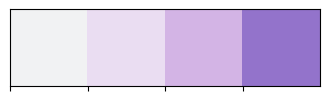

In [ ]:
custom_palette = [
'#f1f2f3',
'#eaddf2',
'#d3b4e5','#9373cb'
]

sns.palplot(custom_palette)
plt.show()

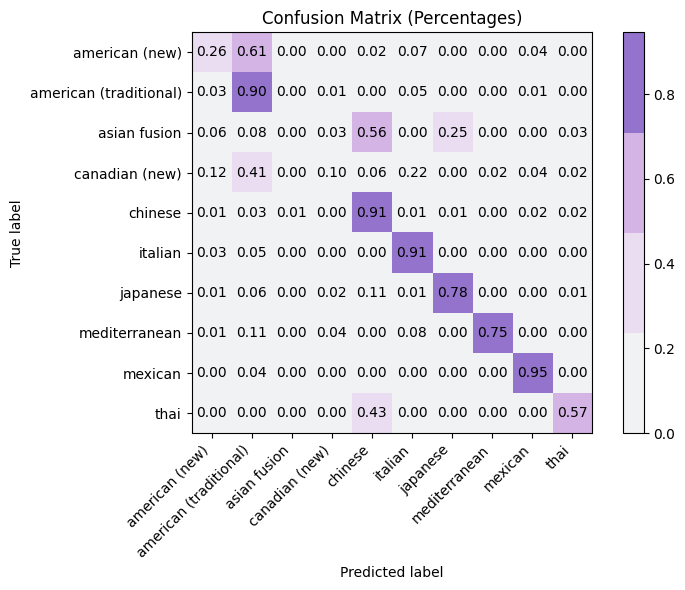

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt


custom_cmap = ListedColormap(custom_palette[0:4])

cm = confusion_matrix(y_val_1, preds_val_1, labels=clf_val_1.classes_)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=clf_val_1.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=custom_cmap, values_format=".2f", ax=ax)

# Improve readability
for text in ax.texts:
    text.set_color("black")

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.title("Confusion Matrix (Percentages)")
plt.tight_layout()
plt.show()


##Model 2

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Model%202.png)

Run pre-processing steps on Restaurant Review + Other Features field this time (instead of just the Reviews only like in Model 1):

In [ ]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)

In [ ]:
model_2_emb_start = datetime.now()

df_train_2=df_train.copy()
df_train_2["text"]=df_train_2["text_review_and_features"]

df_test_2=df_test.copy()
df_test_2["text"]=df_test_2["text_review_and_features"]

# Step 1 Pre-process/tokenize "text"
df_train_2 = preprocess_df(df_train_2)
df_test_2 = preprocess_df(df_test_2)

# Step 2 Tokenize sentences
train_2_tokenized = tokenize_text_column(df_train_2, column="text")
test_2_tokenized  = tokenize_text_column(df_test_2, column="text")

# Step 3 Build Vocabulary of "text"
word_counts, vocabulary, vocabulary_inv = build_vocab(train_2_tokenized)

# Step 4 Create Input Data
inp_data = [[vocabulary[word] for word in text] for text in train_2_tokenized]

# Step 5 Word Embeddings
embedding_weights = get_embeddings(inp_data, vocabulary_inv)

#Step 6 Create Average Word Embedding Vectors
train_vec_2 = average_embedding_vectors(train_2_tokenized, embedding_weights, vocabulary)
test_vec_2  = average_embedding_vectors(test_2_tokenized, embedding_weights, vocabulary)

model_2_emb_end = datetime.now()

model_2_emb_time = model_2_emb_end - model_2_emb_start

Training Word2Vec model...
Model: skip-gram
Saving Word2Vec model embedding


In [ ]:
print(train_2_tokenized[0])

['casual', 'Restaurant', 'named', 'Rush', 'Inn', 'Moderate', 'Price', 'Noisy', 'Located', 'Ohio', 'Full', 'bar', 'Has', 'TV', 'Caters', 'Takeout', 'Casual', 'attire', 'Good', 'lunch', 'Good', 'dinner', 'So', 'stopped', 'way', 'Side', 'Quest', 'street', 'nWe', 'know', 'expect', 'came', 'taco', 'night', 'nIm', 'glad', 'nMostly', 'Rush', 'Inn', 'bar', 'ish', 'place', 'theres', 'plenty', 'back', 'side', 'seating', 'booths', 'The', 'place', 'dark', 'rich', 'wood', 'tone', 'patrons', 'decent', 'folks', 'nThe', 'tacos', 'EXCEPTIONAL', 'selection', 'quite', 'good', 'sorts', 'stuff', 'intend', 'try', 'soon', 'possible', 'think', 'place', 'make', 'nice', 'casual', 'dinner', 'lunch', 'stop', 'need', 'get', 'beverage', 'barkeep', 'wait', 'staff', 'keep', 'em', 'coming', 'nSo', 'quick', 'tasty', 'bite', 'dont', 'walk', 'slow', 'RUSH', 'IN', 'TO', 'THE', 'RUSH', 'INN', 'My', 'boyfriend', 'heard', 'little', 'place', 'near', 'Rush', 'Inn', 'offered', 'board', 'games', 'poutine', 'Friday', 'When', 'arr

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Split%20Data.png)

Split data into 80/10/10 Train, Validation, Test split:

In [ ]:
X_2=train_vec_2
y_2=df_train_2['label']

# Train (80%), Temp (20%) split
X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(
    X_2,y_2,
    test_size=0.2,
    random_state=42,
    stratify=y_2
)

# Temp → Validation (10%), Test (10%) split
X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(
    X_temp_2,
    y_temp_2,
    test_size=0.5,
    random_state=42,
    stratify=y_temp_2
)

# Delete temp vars and print shapes with % of total
del X_temp_2, y_temp_2
total_samples_2 = len(df_train_2)

X_train_2_for_shape = np.array(X_train_2)
y_train_2_for_shape = np.array(y_train_2)
X_val_2_for_shape = np.array(X_val_2)
y_val_2_for_shape = np.array(y_val_2)
X_test_2_for_shape = np.array(X_test_2)
y_test_2_for_shape = np.array(y_test_2)


print(f"the shape of the training set (input) is: {X_train_2_for_shape.shape} ({len(X_train_2_for_shape)/total_samples_2:.1%} of total)")
print(f"the shape of the training set (target) is: {y_train_2_for_shape.shape} ({len(y_train_2_for_shape)/total_samples_2:.1%} of total)\n")

print(f"the shape of the cross validation set (input) is: {X_val_2_for_shape.shape} ({len(X_val_2_for_shape)/total_samples_2:.1%} of total)")
print(f"the shape of the cross validation set (target) is: {y_val_2_for_shape.shape} ({len(y_val_2_for_shape)/total_samples_2:.1%} of total)\n")

print(f"the shape of the test set (input) is: {X_test_2_for_shape.shape} ({len(X_test_2_for_shape)/total_samples_2:.1%} of total)")
print(f"the shape of the test set (target) is: {y_test_2_for_shape.shape} ({len(y_test_2_for_shape)/total_samples_2:.1%} of total)")


the shape of the training set (input) is: (10515, 100) (80.0% of total)
the shape of the training set (target) is: (10515,) (80.0% of total)

the shape of the cross validation set (input) is: (1314, 100) (10.0% of total)
the shape of the cross validation set (target) is: (1314,) (10.0% of total)

the shape of the test set (input) is: (1315, 100) (10.0% of total)
the shape of the test set (target) is: (1315,) (10.0% of total)


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Train%20Model.png)

Train model on Logistic Regression:

In [ ]:
model_2_training_start = datetime.now()

clf_val_2 = LogisticRegression(max_iter=1000).fit(X_train_2, y_train_2)

model_2_training_end = datetime.now()

model_2_time = model_2_emb_time + model_2_training_end - model_2_training_start
model_2_time = f"{model_2_time.total_seconds() / 60:.1f} minutes"
print(f"Model 2 time: {model_2_time}")

Model 2 time: 1.0 minutes


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Model%20Accuracy_%20Validation%20Set.png)

Evaluate Accuracy:

In [ ]:
preds_val_2 = clf_val_2.predict(X_val_2)

val_accuracy_2 = accuracy_score(y_val_2, preds_val_2)
print(f"Validation Accuracy: {val_accuracy_2:.4f}")

Validation Accuracy: 0.7603


Evaluate Accuracy of individual Restaurant Type predictions:

In [ ]:
classification_report_val_2 = classification_report(y_val_2, preds_val_2)
print(classification_report_val_2)

                        precision    recall  f1-score   support

        american (new)       0.56      0.28      0.37       140
american (traditional)       0.62      0.88      0.73       268
          asian fusion       0.00      0.00      0.00        36
        canadian (new)       0.31      0.08      0.13        49
               chinese       0.72      0.93      0.81       169
               italian       0.84      0.92      0.88       203
              japanese       0.84      0.78      0.81       106
         mediterranean       0.92      0.75      0.83        73
               mexican       0.95      0.95      0.95       221
                  thai       0.90      0.55      0.68        49

              accuracy                           0.76      1314
             macro avg       0.67      0.61      0.62      1314
          weighted avg       0.73      0.76      0.73      1314



![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Confusion%20Matrix_%20Validation%20Set.png)

Run confusion matrix to see where predictions are going wrong:


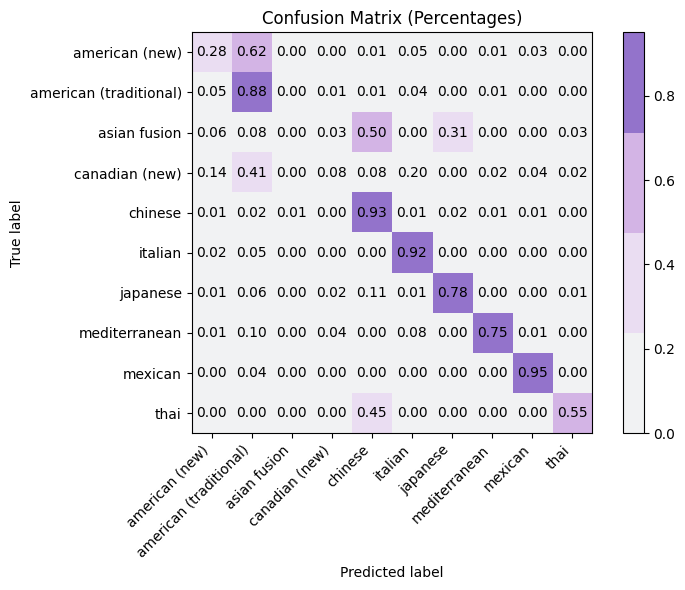

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt


# Create a ListedColormap from your custom palette list
custom_cmap = ListedColormap(custom_palette[0:4])

cm = confusion_matrix(y_val_2, preds_val_2, labels=clf_val_2.classes_)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=clf_val_2.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=custom_cmap, values_format=".2f", ax=ax)

# Improve readability
for text in ax.texts:
    text.set_color("black")

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.title("Confusion Matrix (Percentages)")
plt.tight_layout()
plt.show()

#BERT Transformer Models

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/BERT%20Transformer%20Models.png)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Load%20Libraries.png)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
import torch
import random
import os

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Set%20Seed.png)

Set seed for reproducibility, but NOTE IT IS NOT 100% reproducible, as there is still some level of randomness in Hugging Face Transformer models:

In [ ]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Encode%20Labels.png)

Encode labels as numbers (e.g., "Italian" -> class "1"):

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train["label"].values)
num_classes = len(label_encoder.classes_)

In [ ]:
print(df_train["label"].values)
print(y)

['american (traditional)' 'american (new)' 'mexican' ... 'mexican'
 'japanese' 'chinese']
[1 0 8 ... 8 6 4]


##Model 3

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Model%203.png)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Split%20Data.png)

Split labeled training data into training (80%), validation (10%) and test (10%) sets. This is a common split for NLP and a dataset of this size (13k rows). It also performed better than 70%/15%/15%

In [ ]:
X_3=df_train["text"].values
y_3=y

# Train (80%), Temp (20%) split
X_train_3, X_temp_3, y_train_3, y_temp_3 = train_test_split(
    X_3,
    y_3,
    test_size=0.2,
    random_state=42,
    stratify=y_3
)

# Temp → Validation (10%), Test (10%) split
X_val_3, X_test_3, y_val_3, y_test_3 = train_test_split(
    X_temp_3,
    y_temp_3,
    test_size=0.5,
    random_state=42,
    stratify=y_temp_3
)

# Delete temp vars and print shapes with % of total
del X_temp_3, y_temp_3
total_samples_3 = len(df_train)

print(f"the shape of the training set (input) is: {X_train_3.shape} ({len(X_train_3)/total_samples_3:.1%} of total)")
print(f"the shape of the training set (target) is: {y_train_3.shape} ({len(y_train_3)/total_samples_3:.1%} of total)\n")

print(f"the shape of the cross validation set (input) is: {X_val_3.shape} ({len(X_val_3)/total_samples_3:.1%} of total)")
print(f"the shape of the cross validation set (target) is: {y_val_3.shape} ({len(y_val_3)/total_samples_3:.1%} of total)\n")

print(f"the shape of the test set (input) is: {X_test_3.shape} ({len(X_test_3)/total_samples_3:.1%} of total)")
print(f"the shape of the test set (target) is: {y_test_3.shape} ({len(y_test_3)/total_samples_3:.1%} of total)")


the shape of the training set (input) is: (10515,) (80.0% of total)
the shape of the training set (target) is: (10515,) (80.0% of total)

the shape of the cross validation set (input) is: (1314,) (10.0% of total)
the shape of the cross validation set (target) is: (1314,) (10.0% of total)

the shape of the test set (input) is: (1315,) (10.0% of total)
the shape of the test set (target) is: (1315,) (10.0% of total)


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Tokenize%20Data.png)

Tokenize the text using Bert Tokenizer. Caps each observation at 512 tokens:

*(I tested out different levels but this is the max the model can use and performed the best when it captured as much of the review as possible)*

In [ ]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_texts_with_bert(texts, max_length=512):
  #truncates at 512 tokens per row
    return bert_tokenizer(
        list(texts),
        max_length=max_length,
        padding='max_length',
        truncation=True
    )

train_encodings_3 = tokenize_texts_with_bert(X_train_3)
val_encodings_3 = tokenize_texts_with_bert(X_val_3)
test_encodings_3 = tokenize_texts_with_bert(X_test_3)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Create%20Dataset%20Objects.png)

Creates Hugging Face dataset objects from a Python dictionary of an id, tokenized texts and their labels, to use in training.

In [ ]:
train_dataset_3 = Dataset.from_dict({
    'input_ids': train_encodings_3['input_ids'],
    'attention_mask': train_encodings_3['attention_mask'],
    'labels': list(y_train_3)
})

val_dataset_3 = Dataset.from_dict({
    'input_ids': val_encodings_3['input_ids'],
    'attention_mask': val_encodings_3['attention_mask'],
    'labels': list(y_val_3)
})

test_dataset_3 = Dataset.from_dict({
    'input_ids': test_encodings_3['input_ids'],
    'attention_mask': test_encodings_3['attention_mask'],
    'labels': list(y_test_3)
})


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Train%20Model.png)

Call BERT model for classification:

In [ ]:
model_3 = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_classes,
)
#default dropout is 0.1

Train the BERT model with the following arguments:

In [ ]:
training_args_bert = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4, #3-5 recommended, lower prevents overfitting
    learning_rate=2e-5, #want lower if data is noisy/smaller
    per_device_train_batch_size=16, #lower (8,16) uses less memory
    per_device_eval_batch_size=16,
    warmup_steps=100,
    #gradually increases learning rate at start of training to prevent destabilizing of gradient descent
    weight_decay=0.009, #regularizes to prevent overfitting
    logging_dir='./logs',
    eval_strategy='epoch', #epochs vs. early stopping
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to="none",  # disables W&B logging
    run_name='bert-review-classifier',
    seed=42
)

Build function to calculate accuracy:

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions)
    }

Train the model:

In [ ]:
model_3_start = datetime.now()

bert_trainer_3 = Trainer(
    model=model_3,
    args=training_args_bert,
    train_dataset=train_dataset_3,
    eval_dataset=val_dataset_3,  # val set used during training
    compute_metrics=compute_metrics
)

bert_trainer_3.train()

model_3_end = datetime.now()

model_3_time = model_3_end - model_3_start
model_3_time = f"{model_3_time.total_seconds() / 60:.1f} minutes"
print(f"Model 3 time: {model_3_time}")

Epoch,Training Loss,Validation Loss,Accuracy
1,1.110300,0.663163,0.769406
2,0.561800,0.571752,0.801370
3,0.499700,0.609657,0.787671
4,0.334200,0.630337,0.795282


Model 3 time: 14.6 minutes


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Model%20Accuracy_%20Validation%20Set.png)

Evaluate the accuracy of the predictions:

In [ ]:
val_results_3 = bert_trainer_3.evaluate(val_dataset_3)
print(f"\n Validation Accuracy: {val_results_3['eval_accuracy']:.4f}")


 Validation Accuracy: 0.8014


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Classification%20Report_%20Validation%20Set.png)

View accuracy by class (restaurant type) and accuracy type (precision vs. recall vs. F1):

Improvements were optimized to the F1 score during modeling:

In [ ]:
val_predictions_3 = bert_trainer_3.predict(val_dataset_3)
y_val_pred_3 = np.argmax(val_predictions_3.predictions, axis=1)
y_val_true_3 = val_predictions_3.label_ids

val_report_3 = classification_report(y_val_true_3, y_val_pred_3, target_names=label_encoder.classes_)
print("\n Validation Classification Report:\n", val_report_3)


 Validation Classification Report:
                         precision    recall  f1-score   support

        american (new)       0.53      0.39      0.45       140
american (traditional)       0.67      0.78      0.72       268
          asian fusion       0.40      0.39      0.39        36
        canadian (new)       0.39      0.31      0.34        49
               chinese       0.90      0.89      0.90       169
               italian       0.90      0.96      0.93       203
              japanese       0.90      0.92      0.91       106
         mediterranean       0.94      0.81      0.87        73
               mexican       0.98      0.98      0.98       221
                  thai       0.83      0.88      0.85        49

              accuracy                           0.80      1314
             macro avg       0.74      0.73      0.73      1314
          weighted avg       0.79      0.80      0.80      1314



![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Confusion%20Matrix_%20Validation%20Set.png)

Run confusion matrix to see where exactly predictions are going wrong:

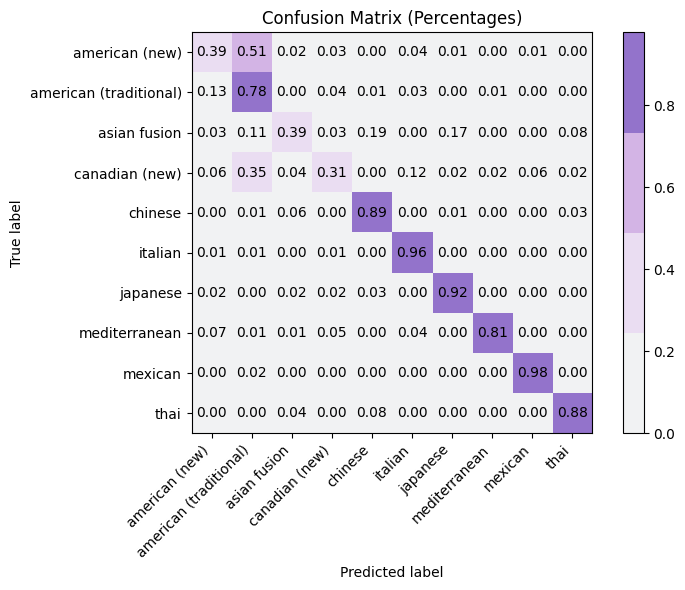

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

# Gives original labels in the correct encoded order
label_names = label_encoder.classes_

custom_cmap = ListedColormap(custom_palette[0:4])

# Compute confusion matrix and percentages
cm = confusion_matrix(y_val_true_3, y_val_pred_3, labels=range(len(label_names)))
cm_percent = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=custom_cmap, values_format=".2f", ax=ax)

# Improve readability
for text in ax.texts:
    text.set_color("black")

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.title("Confusion Matrix (Percentages)")
plt.tight_layout()
plt.show()

##Model 4

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Model%204.png)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Split%20Data.png)

Perform same steps as Model 3:

Split data into 80/10/10 Train, Validation, Test split:

In [ ]:
X_4=df_train["text_review_and_features"].values
y_4=y

# Train (80%), Temp (20%) split
X_train_4, X_temp_4, y_train_4, y_temp_4 = train_test_split(
    X_4,
    y_4,
    test_size=0.2,
    random_state=42,
    stratify=y_4
)

# Temp → Validation (10%), Test (10%) split
X_val_4, X_test_4, y_val_4, y_test_4 = train_test_split(
    X_temp_4,
    y_temp_4,
    test_size=0.5,
    random_state=42,
    stratify=y_temp_4
)

# Delete temp vars and print shapes with % of total
del X_temp_4, y_temp_4
total_samples_4 = len(df_train)

print(f"the shape of the training set (input) is: {X_train_4.shape} ({len(X_train_4)/total_samples_4:.1%} of total)")
print(f"the shape of the training set (target) is: {y_train_4.shape} ({len(y_train_4)/total_samples_4:.1%} of total)\n")

print(f"the shape of the cross validation set (input) is: {X_val_4.shape} ({len(X_val_4)/total_samples_4:.1%} of total)")
print(f"the shape of the cross validation set (target) is: {y_val_4.shape} ({len(y_val_4)/total_samples_4:.1%} of total)\n")

print(f"the shape of the test set (input) is: {X_test_4.shape} ({len(X_test_4)/total_samples_4:.1%} of total)")
print(f"the shape of the test set (target) is: {y_test_4.shape} ({len(y_test_4)/total_samples_4:.1%} of total)")


the shape of the training set (input) is: (10515,) (80.0% of total)
the shape of the training set (target) is: (10515,) (80.0% of total)

the shape of the cross validation set (input) is: (1314,) (10.0% of total)
the shape of the cross validation set (target) is: (1314,) (10.0% of total)

the shape of the test set (input) is: (1315,) (10.0% of total)
the shape of the test set (target) is: (1315,) (10.0% of total)


In [ ]:
train_encodings_4 = tokenize_texts_with_bert(X_train_4)
val_encodings_4 = tokenize_texts_with_bert(X_val_4)
test_encodings_4 = tokenize_texts_with_bert(X_test_4)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Train%20Model.png)

Create Hugging Face Datasets for Train, Val, Test:

In [ ]:
train_dataset_4 = Dataset.from_dict({
    'input_ids': train_encodings_4['input_ids'],
    'attention_mask': train_encodings_4['attention_mask'],
    'labels': list(y_train_4)
})

val_dataset_4 = Dataset.from_dict({
    'input_ids': val_encodings_4['input_ids'],
    'attention_mask': val_encodings_4['attention_mask'],
    'labels': list(y_val_4)
})

test_dataset_4 = Dataset.from_dict({
    'input_ids': test_encodings_4['input_ids'],
    'attention_mask': test_encodings_4['attention_mask'],
    'labels': list(y_test_4)
})

Call pre-trained BERT model:

In [ ]:
model_4 = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_classes,
)
#default dropout is 0.1

Train model:

In [ ]:
model_4_start = datetime.now()

bert_trainer_4 = Trainer(
    model=model_4,
    args=training_args_bert, #used same training args as model 3
    train_dataset=train_dataset_4,
    eval_dataset=val_dataset_4,  # val set used during training
    compute_metrics=compute_metrics
)

bert_trainer_4.train()

model_4_end = datetime.now()

model_4_time = model_4_end - model_4_start
model_4_time = f"{model_4_time.total_seconds() / 60:.1f} minutes"
print(f"Model 4 time: {model_4_time}")

Epoch,Training Loss,Validation Loss,Accuracy
1,1.060000,0.566824,0.791476
2,0.504900,0.503266,0.817352
3,0.437800,0.530312,0.822679
4,0.283300,0.560896,0.821918


Model 4 time: 14.6 minutes


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Model%20Accuracy_%20Validation%20Set.png)

Evaluate accuracy:

In [ ]:
val_results_4 = bert_trainer_4.evaluate(val_dataset_4)
print(f"\n Validation Accuracy: {val_results_4['eval_accuracy']:.4f}")


 Validation Accuracy: 0.8174


Run classification report to view accuracy by Restaurant Type (class):

In [ ]:
val_predictions_4 = bert_trainer_4.predict(val_dataset_4)
y_val_pred_4 = np.argmax(val_predictions_4.predictions, axis=1)
y_val_true_4 = val_predictions_4.label_ids

val_report_4 = classification_report(y_val_true_4, y_val_pred_4, target_names=label_encoder.classes_)
print("\n Validation Classification Report:\n", val_report_4)


 Validation Classification Report:
                         precision    recall  f1-score   support

        american (new)       0.58      0.61      0.59       140
american (traditional)       0.78      0.69      0.73       268
          asian fusion       0.52      0.39      0.44        36
        canadian (new)       0.39      0.65      0.48        49
               chinese       0.91      0.93      0.92       169
               italian       0.91      0.92      0.91       203
              japanese       0.89      0.95      0.92       106
         mediterranean       0.91      0.81      0.86        73
               mexican       0.97      0.97      0.97       221
                  thai       0.95      0.86      0.90        49

              accuracy                           0.82      1314
             macro avg       0.78      0.78      0.77      1314
          weighted avg       0.83      0.82      0.82      1314



![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Confusion%20Matrix_%20Validation%20Set.png)

Run Confusion Matrix to see where predictions are going wrong:

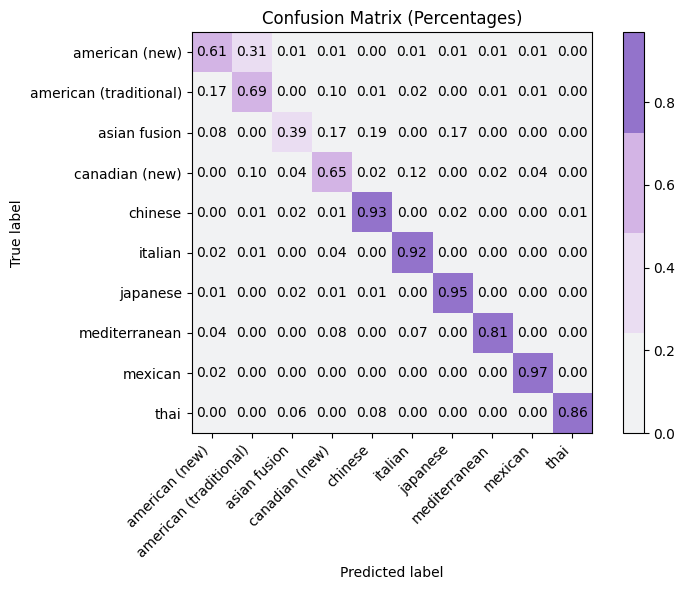

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

# Gives the original labels in the correct encoded order
label_names = label_encoder.classes_

custom_cmap = ListedColormap(custom_palette[0:4])

# Compute confusion matrix and percentages
cm = confusion_matrix(y_val_true_4, y_val_pred_4, labels=range(len(label_names)))
cm_percent = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=custom_cmap, values_format=".2f", ax=ax)

# Improve readability
for text in ax.texts:
    text.set_color("black")

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.title("Confusion Matrix (Percentages)")
plt.tight_layout()
plt.show()

#RoBERTa Transformer Model

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/RoBERTa%20Transformer%20Model.png)

##Model 5

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Model%205.png)

Use a different transformer model (Roberta) and run it on the Review + Other Features data as Model 5:

Differences between RoBERTa and BERT:


*   RoBERTa is better trained and on more data
*   Removes Next Sentence Prediction, focuses only on masked language modeling
*   Has dynamic masking (changing masked tokens during training) vs. static masking
*   Uses one sequences instead of splitting sentences
*   RoBERTa generally achieves higher accuracy than BERT

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Load%20Libraries.png)

Load libraries for RoBERTa model:

In [ ]:
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Split%20Data.png)

Split data into 80/10/10 Train, Validation, Test:

In [ ]:
X_5=df_train["text_review_and_features"].values
y_5=y

# Train (80%), Temp (20%) split
X_train_5, X_temp_5, y_train_5, y_temp_5 = train_test_split(
    X_5,
    y_5,
    test_size=0.2,
    random_state=42,
    stratify=y_5
)

# Temp → Validation (10%), Test (10%) split
X_val_5, X_test_5, y_val_5, y_test_5 = train_test_split(
    X_temp_5,
    y_temp_5,
    test_size=0.5,
    random_state=42,
    stratify=y_temp_5
)

# Delete temp vars and print shapes with % of total
del X_temp_5, y_temp_5
total_samples_5 = len(df_train)

print(f"the shape of the training set (input) is: {X_train_5.shape} ({len(X_train_5)/total_samples_5:.1%} of total)")
print(f"the shape of the training set (target) is: {y_train_5.shape} ({len(y_train_5)/total_samples_5:.1%} of total)\n")

print(f"the shape of the cross validation set (input) is: {X_val_5.shape} ({len(X_val_5)/total_samples_5:.1%} of total)")
print(f"the shape of the cross validation set (target) is: {y_val_5.shape} ({len(y_val_5)/total_samples_5:.1%} of total)\n")

print(f"the shape of the test set (input) is: {X_test_5.shape} ({len(X_test_5)/total_samples_5:.1%} of total)")
print(f"the shape of the test set (target) is: {y_test_5.shape} ({len(y_test_5)/total_samples_5:.1%} of total)")


the shape of the training set (input) is: (10515,) (80.0% of total)
the shape of the training set (target) is: (10515,) (80.0% of total)

the shape of the cross validation set (input) is: (1314,) (10.0% of total)
the shape of the cross validation set (target) is: (1314,) (10.0% of total)

the shape of the test set (input) is: (1315,) (10.0% of total)
the shape of the test set (target) is: (1315,) (10.0% of total)


Tokenize data with pre-trained Roberta model:

In [ ]:
roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

def tokenize_texts_with_roberta(texts, max_length=512):
  #truncates at 512 tokens per row
    return roberta_tokenizer(
        list(texts),
        max_length=max_length,
        padding='max_length',
        truncation=True
    )

In [ ]:
train_encodings_5 = tokenize_texts_with_roberta(X_train_5)
val_encodings_5 = tokenize_texts_with_roberta(X_val_5)
test_encodings_5 = tokenize_texts_with_roberta(X_test_5)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Train%20Model.png)

Create Hugging Face datasets for Train, Val, Test:

In [ ]:
train_dataset_5 = Dataset.from_dict({
    'input_ids': train_encodings_5['input_ids'],
    'attention_mask': train_encodings_5['attention_mask'],
    'labels': list(y_train_5)
})

val_dataset_5 = Dataset.from_dict({
    'input_ids': val_encodings_5['input_ids'],
    'attention_mask': val_encodings_5['attention_mask'],
    'labels': list(y_val_5)
})

test_dataset_5 = Dataset.from_dict({
    'input_ids': test_encodings_5['input_ids'],
    'attention_mask': test_encodings_5['attention_mask'],
    'labels': list(y_test_5)
})

Call RoBERTA model, this one includes dropout regularization of 0.1
Dropout randomly sets a percentage of the layer’s outputs to 0 in training
to force the model not to rely too much on any one neuron:

In [ ]:
# Load model with dropout regularization (default dropout for RoBERTa is 0.1)
model_5 = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=num_classes,
)

Set training arguments:

In [ ]:
#Training arguments
training_args_roberta = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4, #lower prevents overfitting
    learning_rate=2e-5, #want lower if data is noisy/smaller
    per_device_train_batch_size=16, #lower (8,16) uses less memory
    per_device_eval_batch_size=16,
    warmup_steps=100,
    #gradually increases learning rate at start of training to prevent destabilizing of gradient descent
    weight_decay=0.009, #regularizes to prevent overfitting
    logging_dir='./logs',
    eval_strategy='epoch', #epochs vs. early stopping
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to="none",  # disables W&B logging
    run_name='roberta-review-classifier'
)

Train the model:

In [ ]:
model_5_start = datetime.now()

roberta_trainer_5 = Trainer(
    model=model_5,
    args=training_args_roberta,
    train_dataset=train_dataset_5,
    eval_dataset=val_dataset_5,  # val set used during training
    compute_metrics=compute_metrics
)

roberta_trainer_5.train()

model_5_end = datetime.now()

model_5_time = model_5_end - model_5_start

model_5_time = f"{model_5_time.total_seconds() / 60:.1f} minutes"
print(f"Model 5 time: {model_5_time}")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.954900,0.544267,0.806697
2,0.495800,0.506158,0.820396
3,0.451700,0.512645,0.828767
4,0.306900,0.540284,0.829528


Model 5 time: 14.7 minutes


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Model%20Accuracy_%20Validation%20Set.png)

Evaluate accuracy of predictions:

In [ ]:
val_results_5 = roberta_trainer_5.evaluate(val_dataset_5)
print(f"\n Validation Accuracy: {val_results_5['eval_accuracy']:.4f}")


 Validation Accuracy: 0.8204


Run classification report to show accuracy on Restaurant Type (class) level:

In [ ]:
val_predictions_5 = roberta_trainer_5.predict(val_dataset_5)
y_val_pred_5 = np.argmax(val_predictions_5.predictions, axis=1)
y_val_true_5 = val_predictions_5.label_ids

val_report_5 = classification_report(y_val_true_5, y_val_pred_5, target_names=label_encoder.classes_)
print("\n Validation Classification Report:\n", val_report_5)


 Validation Classification Report:
                         precision    recall  f1-score   support

        american (new)       0.59      0.56      0.57       140
american (traditional)       0.77      0.69      0.73       268
          asian fusion       0.48      0.39      0.43        36
        canadian (new)       0.40      0.67      0.50        49
               chinese       0.88      0.93      0.90       169
               italian       0.90      0.94      0.92       203
              japanese       0.91      0.99      0.95       106
         mediterranean       0.93      0.86      0.89        73
               mexican       0.99      0.97      0.98       221
                  thai       0.97      0.80      0.88        49

              accuracy                           0.82      1314
             macro avg       0.78      0.78      0.78      1314
          weighted avg       0.83      0.82      0.82      1314



Run confusion matrix to see where predictions are going wrong:

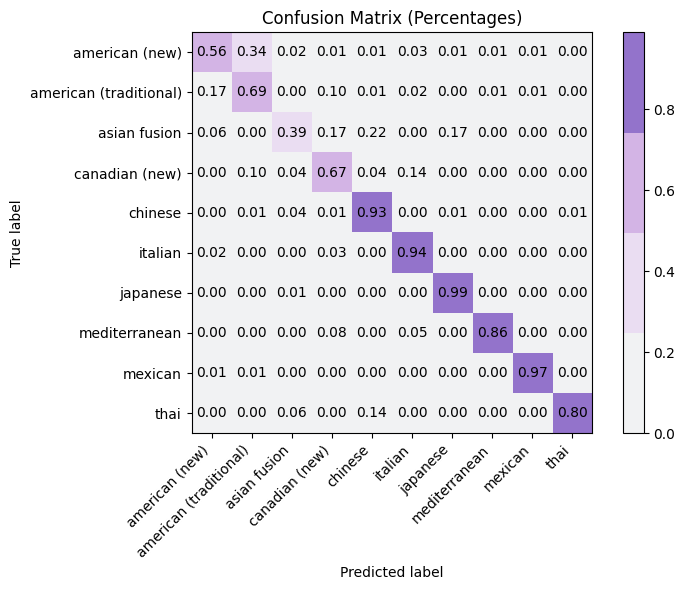

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

# Gives the original labels in the correct encoded order
label_names = label_encoder.classes_

custom_cmap = ListedColormap(custom_palette[0:4])

# Compute confusion matrix and percentages
cm = confusion_matrix(y_val_true_5, y_val_pred_5, labels=range(len(label_names)))
cm_percent = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=label_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap=custom_cmap, values_format=".2f", ax=ax)

# Improve readability
for text in ax.texts:
    text.set_color("black")

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.title("Confusion Matrix (Percentages)")
plt.tight_layout()
plt.show()

#Model Comparison

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Model%20Comparison.png)

![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Test%20Set%20Accuracies%20All%20Models.png)

Model 1 Test Accuracy:

In [ ]:
clf_test_1 = LogisticRegression(max_iter=1000).fit(train_vec_1, df_train_1["label"])

preds_test_1 = clf_test_1.predict(X_test_1)

test_accuracy_1 = accuracy_score(y_test_1, preds_test_1)
print(f"Model 1 Test Accuracy: {test_accuracy_1:.4f}")

Model 1 Test Accuracy: 0.7772


In [ ]:
classification_report_test_1=classification_report(y_test_1, preds_test_1, zero_division=0)
print(classification_report_test_1)

                        precision    recall  f1-score   support

        american (new)       0.53      0.33      0.41       140
american (traditional)       0.63      0.85      0.72       268
          asian fusion       1.00      0.03      0.05        36
        canadian (new)       0.25      0.04      0.07        48
               chinese       0.80      0.92      0.86       170
               italian       0.84      0.94      0.88       203
              japanese       0.86      0.86      0.86       107
         mediterranean       0.84      0.79      0.82        73
               mexican       0.97      0.94      0.95       222
                  thai       0.93      0.83      0.88        48

              accuracy                           0.78      1315
             macro avg       0.76      0.65      0.65      1315
          weighted avg       0.77      0.78      0.75      1315



In [ ]:
from sklearn.metrics import classification_report

classification_report_dict_1 = classification_report(
    y_test_1,
    preds_test_1,
    target_names=label_encoder.classes_,
    output_dict=True
)

weighted_f1_1 = classification_report_dict_1['weighted avg']['f1-score']
print(f"Model 1 Weighted F1 Score: {weighted_f1_1:.1%}")

Model 1 Weighted F1 Score: 75.0%


Model 2 Test Accuracy:

In [ ]:
clf_test_2 = LogisticRegression(max_iter=1000).fit(train_vec_2, df_train_2["label"])

preds_test_2 = clf_test_2.predict(X_test_2)

test_accuracy_2 = accuracy_score(y_test_2, preds_test_2)
print(f"Model 2 Test Accuracy: {test_accuracy_2:.4f}")

Model 2 Test Accuracy: 0.7772


In [ ]:
classification_report_test_2 = classification_report(y_test_2, preds_test_2)
print(classification_report_test_2)

                        precision    recall  f1-score   support

        american (new)       0.52      0.33      0.40       140
american (traditional)       0.63      0.84      0.72       268
          asian fusion       1.00      0.03      0.05        36
        canadian (new)       0.33      0.06      0.11        48
               chinese       0.78      0.93      0.85       170
               italian       0.84      0.94      0.89       203
              japanese       0.86      0.84      0.85       107
         mediterranean       0.84      0.81      0.83        73
               mexican       0.97      0.95      0.96       222
                  thai       0.97      0.81      0.89        48

              accuracy                           0.78      1315
             macro avg       0.78      0.65      0.65      1315
          weighted avg       0.77      0.78      0.75      1315



In [ ]:
from sklearn.metrics import classification_report

classification_report_dict_2 = classification_report(
    y_test_2,
    preds_test_2,
    target_names=label_encoder.classes_,
    output_dict=True
)

weighted_f1_2 = classification_report_dict_2['weighted avg']['f1-score']
print(f"Model 2 Weighted F1 Score: {weighted_f1_2:.1%}")

Model 2 Weighted F1 Score: 75.1%


Model 3 Test Accuracy:

In [ ]:
test_predictions_3 = bert_trainer_3.predict(test_dataset_3)
y_test_pred_3 = np.argmax(test_predictions_3.predictions, axis=1)
y_test_true_3 = test_predictions_3.label_ids

test_accuracy_3 = bert_trainer_3.evaluate(test_dataset_3)
print(f"\n Model 3 Test Accuracy: {test_accuracy_3['eval_accuracy']:.4f}")
test_accuracy_3 = test_accuracy_3['eval_accuracy']


 Model 3 Test Accuracy: 0.8068


In [ ]:
classification_report_test_3 = classification_report(y_test_true_3, y_test_pred_3, target_names=label_encoder.classes_)
print("\n Model 3 Test Classification Report:\n", classification_report_test_3)


 Model 3 Test Classification Report:
                         precision    recall  f1-score   support

        american (new)       0.51      0.46      0.49       140
american (traditional)       0.69      0.74      0.71       268
          asian fusion       0.50      0.47      0.49        36
        canadian (new)       0.46      0.33      0.39        48
               chinese       0.93      0.93      0.93       170
               italian       0.88      0.94      0.91       203
              japanese       0.90      0.93      0.92       107
         mediterranean       0.86      0.84      0.85        73
               mexican       0.97      0.95      0.96       222
                  thai       0.94      0.94      0.94        48

              accuracy                           0.81      1315
             macro avg       0.76      0.75      0.76      1315
          weighted avg       0.80      0.81      0.80      1315



In [ ]:
from sklearn.metrics import classification_report

classification_report_dict_3 = classification_report(
    y_test_true_3,
    y_test_pred_3,
    target_names=label_encoder.classes_,
    output_dict=True
)

weighted_f1_3 = classification_report_dict_3['weighted avg']['f1-score']
print(f"Model 3 Weighted F1 Score: {weighted_f1_3:.1%}")

Model 3 Weighted F1 Score: 80.3%


Model 4 Test Accuracy:

In [ ]:
test_predictions_4 = bert_trainer_4.predict(test_dataset_4)
y_test_pred_4 = np.argmax(test_predictions_4.predictions, axis=1)
y_test_true_4 = test_predictions_4.label_ids

test_accuracy_4 = bert_trainer_4.evaluate(test_dataset_4)
print(f"\n Model 4 Test Accuracy: {test_accuracy_4['eval_accuracy']:.4f}")
test_accuracy_4 = test_accuracy_4['eval_accuracy']


 Model 4 Test Accuracy: 0.8274


In [ ]:
classification_report_test_4 = classification_report(y_test_true_4, y_test_pred_4, target_names=label_encoder.classes_)
print("\n Model 4 Test Classification Report:\n", classification_report_test_4)


 Model 4 Test Classification Report:
                         precision    recall  f1-score   support

        american (new)       0.58      0.64      0.61       140
american (traditional)       0.78      0.70      0.74       268
          asian fusion       0.55      0.50      0.52        36
        canadian (new)       0.48      0.67      0.56        48
               chinese       0.92      0.91      0.91       170
               italian       0.89      0.95      0.92       203
              japanese       0.88      0.91      0.89       107
         mediterranean       0.91      0.85      0.88        73
               mexican       0.98      0.95      0.96       222
                  thai       1.00      0.90      0.95        48

              accuracy                           0.83      1315
             macro avg       0.80      0.80      0.79      1315
          weighted avg       0.83      0.83      0.83      1315



In [ ]:
from sklearn.metrics import classification_report

classification_report_dict_4 = classification_report(
    y_test_true_4,
    y_test_pred_4,
    target_names=label_encoder.classes_,
    output_dict=True
)

weighted_f1_4 = classification_report_dict_4['weighted avg']['f1-score']
print(f"Model 4 Weighted F1 Score: {weighted_f1_4:.1%}")

Model 4 Weighted F1 Score: 82.9%


Model 5 Test Accuracy:

In [ ]:
test_predictions_5 = roberta_trainer_5.predict(test_dataset_5)
y_test_pred_5 = np.argmax(test_predictions_5.predictions, axis=1)
y_test_true_5 = test_predictions_5.label_ids

test_accuracy_5 = roberta_trainer_5.evaluate(test_dataset_5)
print(f"\n Model 5 Test Accuracy: {test_accuracy_5['eval_accuracy']:.4f}")
test_accuracy_5 = test_accuracy_5['eval_accuracy']


 Model 5 Test Accuracy: 0.8205


In [ ]:
classification_report_test_5 = classification_report(y_test_true_5, y_test_pred_5, target_names=label_encoder.classes_)
print("\n Model 5 Test Classification Report:\n", classification_report_test_5)


 Model 5 Test Classification Report:
                         precision    recall  f1-score   support

        american (new)       0.56      0.61      0.59       140
american (traditional)       0.78      0.67      0.72       268
          asian fusion       0.51      0.50      0.51        36
        canadian (new)       0.49      0.75      0.59        48
               chinese       0.93      0.92      0.92       170
               italian       0.89      0.93      0.91       203
              japanese       0.88      0.92      0.89       107
         mediterranean       0.90      0.82      0.86        73
               mexican       0.98      0.95      0.97       222
                  thai       0.98      0.92      0.95        48

              accuracy                           0.82      1315
             macro avg       0.79      0.80      0.79      1315
          weighted avg       0.83      0.82      0.82      1315



In [ ]:
from sklearn.metrics import classification_report

classification_report_dict_5 = classification_report(
    y_test_true_5,
    y_test_pred_5,
    target_names=label_encoder.classes_,
    output_dict=True
)

weighted_f1_5 = classification_report_dict_5['weighted avg']['f1-score']
print(f"Model 5 Weighted F1 Score: {weighted_f1_5:.1%}")


Model 5 Weighted F1 Score: 82.3%


![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/2_images/templates/notebook/headers/light_teal/Final%20Comparison%20Charts.png)

Comparison Chart for Weighted F-1 Score:

In [ ]:
import pandas as pd

# Round and convert to percent strings
wf1_1 = f"{round(weighted_f1_1 * 100, 1)}%"
wf1_2 = f"{round(weighted_f1_2 * 100, 1)}%"
wf1_3 = f"{round(weighted_f1_3 * 100, 1)}%"
wf1_4 = f"{round(weighted_f1_4 * 100, 1)}%"
wf1_5 = f"{round(weighted_f1_5 * 100, 1)}%"


# Create DataFrame
w_f1_df = pd.DataFrame({
    'Model #': ['1', '2','3','4','5'],
    'Model': ['Logistic Regression', 'Logistic Regression','BERT','BERT','RoBERTa'],
    'Model Description': ['Avg. Word2Vec Embeddings', 'Avg. Word2Vec Embeddings','Transformer','Transformer','Transformer'],
    'Weighted F-1 Score': [wf1_1, wf1_2, wf1_3, wf1_4, wf1_5],
    'Time (min)': [model_1_time, model_2_time, model_3_time, model_4_time, model_5_time],
    'Type': ['Baseline', 'Candidate', 'Candidate','Final','Candidate',]
})

w_f1_df


,Model #,Model,Model Description,Weighted F-1 Score,Time (min),Type
0,1,Logistic Regression,Avg. Word2Vec Embeddings,75.0%,0.4 minutes,Baseline
1,2,Logistic Regression,Avg. Word2Vec Embeddings,75.1%,1.0 minutes,Candidate
2,3,BERT,Transformer,80.3%,14.6 minutes,Candidate
3,4,BERT,Transformer,82.9%,14.6 minutes,Final
4,5,RoBERTa,Transformer,82.3%,14.7 minutes,Candidate


Comparison chart for classification report:

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate reports
report_1 = classification_report(y_test_1, preds_test_1, zero_division=0, output_dict=True)
report_2 = classification_report(y_test_2, preds_test_2, zero_division=0, output_dict=True)
report_3 = classification_report(y_test_true_3, y_test_pred_3, zero_division=0, output_dict=True, target_names=label_encoder.classes_)
report_4 = classification_report(y_test_true_4, y_test_pred_4, zero_division=0, output_dict=True, target_names=label_encoder.classes_)
report_5 = classification_report(y_test_true_5, y_test_pred_5, zero_division=0, output_dict=True, target_names=label_encoder.classes_)

# Convert to DataFrames
df1 = pd.DataFrame(report_1).T[['f1-score']].rename(columns={'f1-score': 'Model 1: Avg. Embeddings Review Only'})
df2 = pd.DataFrame(report_2).T[['f1-score']].rename(columns={'f1-score': 'Model 2: Avg. Embeddings Review+Features'})
df3 = pd.DataFrame(report_3).T[['f1-score']].rename(columns={'f1-score': 'Model 3: BERT Review Only'})
df4 = pd.DataFrame(report_4).T[['f1-score']].rename(columns={'f1-score': 'Model 4: BERT Review + Features'})
df5 = pd.DataFrame(report_5).T[['f1-score']].rename(columns={'f1-score': 'Model 5: RoBERTa Review + Features'})

# Combine
comparison_df = pd.concat([df1, df2, df3, df4, df5], axis=1)

# Separate summary rows and class rows
summary_rows = ['accuracy', 'macro avg', 'weighted avg']
summary_df = comparison_df.loc[summary_rows]
class_df = comparison_df.drop(index=summary_rows)

# Combine summary first, then classes
final_df = pd.concat([summary_df, class_df])


Formatted/Final F1 Comparison Chart:

NOTE: Pasted images of report since final chart needed to be hidden to save to Github due to Plotly widget compatibility issue:

 ![Alt text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/1_projects/machine_learning/NLP/restaurant_prediction_nlp/final_accuracy_report.png)

![Alt Text](https://github.com/lindsayalexandra14/ds_portfolio/raw/main/1_projects/machine_learning/NLP/restaurant_prediction_nlp/final_classification_report.png)

Hid plotly chart:

In [ ]:
# import plotly.graph_objects as go

# # Format as percentage where applicable
# def format_percent(df):
#     return df.copy().apply(lambda col: col.map(lambda x: f"{x*100:.1f}%" if isinstance(x, float) else x))

# # Split summary and class rows
# summary_rows = ['accuracy', 'macro avg', 'weighted avg']
# summary_df = format_percent(comparison_df.loc[summary_rows].reset_index())
# summary_df.columns = ['Metric'] + list(summary_df.columns[1:])

# class_df = format_percent(comparison_df.drop(index=summary_rows, errors='ignore').reset_index())
# class_df.columns = ['Class'] + list(class_df.columns[1:])

# # Colors
# body = '#fdfdfe'
# header = '#d3b4e5'

# def make_table(data, height):
#     fig = go.Figure(data=[go.Table(
#         header=dict(
#             values=list(data.columns),
#             fill_color=header,
#             font=dict(color='black', size=12),
#             align='center'
#         ),
#         cells=dict(
#             values=[data[col] for col in data.columns],
#             fill_color=body,
#             font=dict(color='gray', size=12),
#             align='center'
#         )
#     )])
#     fig.update_layout(width=950, height=height, margin=dict(l=15, r=15, t=20, b=10))
#     return fig

# # Show both tables
# make_table(summary_df, 300).show()
# make_table(class_df, 300).show()


Just a note that I evaluated performance based on weighted F1 average because of the following class imbalance:

In [ ]:
# Absolute counts
print(df_train['label'].value_counts())

# Relative proportions (percentages)
print(df_train['label'].value_counts(normalize=True).map(lambda x: f"{x*100:.1f}%"))


label
american (traditional)    2680
mexican                   2217
italian                   2032
chinese                   1696
american (new)            1399
japanese                  1063
mediterranean              728
canadian (new)             484
thai                       483
asian fusion               362
Name: count, dtype: int64
label
american (traditional)    20.4%
mexican                   16.9%
italian                   15.5%
chinese                   12.9%
american (new)            10.6%
japanese                   8.1%
mediterranean              5.5%
canadian (new)             3.7%
thai                       3.7%
asian fusion               2.8%
Name: proportion, dtype: object
